# Overview

### This project presents the development of a comprehensive customer analytics system aimed at enhancing decision-making within the e-commerce sector. The solution leverages a combination of behavioral, transactional, and demographic data to perform advanced customer segmentation using techniques such as RFM analysis and KMeans clustering.

### Beyond segmentation, the system integrates predictive modeling capabilities to identify high-risk churn customers and forecast Customer Lifetime Value (CLV), applying machine learning algorithms including Random Forest, XGBoost, and Logistic Regression. To ensure explainability, SHAP-based model interpretation is implemented.

### The final output is deployed via a user-friendly, interactive Streamlit dashboard, allowing real-time CSV uploads, customer lookup, segment filtering, and actionable business insights. The project aims to bridge the gap between raw customer data and strategic business planning by delivering a scalable, AI-driven solution suitable for real-world applications.

# PHASE 0: Project Initialization

## Step 0.1 – Create Project Folder Structure

In [1]:
import os

# Define root project folder
project_root = "CustomerSegmentAI360"

# Folder structure
folders = [
    "Datasets",
    "Processed",
    "Outputs/Visuals/Phase1",
    "Outputs/Visuals/Phase2",
    "Outputs/Visuals/Phase3",
    "Outputs/Visuals/Phase4",
    "Outputs/Visuals/Phase5",
    "Outputs/Visuals/Phase6",
    "Models",
    "Dashboard"
]

# Create folders
for folder in folders:
    os.makedirs(os.path.join(project_root, folder), exist_ok=True)

print("Project folder structure created.")


Project folder structure created.


## Step 0.2 – Import and Install Required Libraries

In [2]:
# Data handling
import pandas as pd
import numpy as np
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, accuracy_score, f1_score, precision_score, recall_score
)

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Clustering and dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

# Explainability
import shap

# Settings
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')


## Step 0.3 – Define Global Visual Theme and Save Function

In [3]:
# Global visualization theme
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Reusable function to save figures
def save_figure(fig, filename, phase_folder):
    """
    Save a matplotlib figure to the specified phase's visuals folder.
    
    Parameters:
    - fig: The matplotlib figure object
    - filename: Name of the file (e.g., 'distribution.png')
    - phase_folder: Folder name like 'Phase2', 'Phase4', etc.
    """
    path = os.path.join(project_root, "Outputs", "Visuals", phase_folder, filename)
    fig.savefig(path, bbox_inches='tight')
    print(f"Saved figure: {path}")


# PHASE 1: Data Loading & Merging

## Step 1.1 – Load Datasets Online Retail & Online Retail II

In [4]:
# Define paths
retail1_path = os.path.join(project_root, "Datasets", "online_retail.csv")         # Data Source kaggle
retail2_path = os.path.join(project_root, "Datasets", "online_retail_II.csv")      # Data Source UCI

# Load datasets
retail1 = pd.read_csv(retail1_path, encoding='ISO-8859-1')
retail2 = pd.read_csv(retail2_path, encoding='ISO-8859-1')

# Preview shapes and columns
print("Retail 1 Shape:", retail1.shape)
print("Retail 2 Shape:", retail2.shape)
print("\nRetail 1 Columns:", retail1.columns.tolist())
print("Retail 2 Columns:", retail2.columns.tolist())

# Save initial info for sanity check
retail1.info()
retail2.info()


Retail 1 Shape: (541909, 8)
Retail 2 Shape: (1067371, 8)

Retail 1 Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']
Retail 2 Columns: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (

## Step 1.2 – Concatenate and Clean Unified Retail Dataset

In [5]:
# Concatenate datasets
retail_combined = pd.concat([retail1, retail2], ignore_index=True)

# Drop exact duplicates
retail_combined.drop_duplicates(inplace=True)

# Optional: Filter only UK transactions
retail_combined = retail_combined[retail_combined['Country'] == 'United Kingdom']

# Reset index
retail_combined.reset_index(drop=True, inplace=True)

# Basic preview
print("Combined Retail Dataset Shape:", retail_combined.shape)
retail_combined.head(3)


Combined Retail Dataset Shape: (1438621, 11)


InvoiceNo StockCode                         Description  Quantity  \
0    536365    85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                 WHITE METAL LANTERN         6   
2    536365    84406B      CREAM CUPID HEARTS COAT HANGER         8   

           InvoiceDate  UnitPrice  CustomerID         Country Invoice  Price  \
0  2010-12-01 08:26:00       2.55     17850.0  United Kingdom     NaN    NaN   
1  2010-12-01 08:26:00       3.39     17850.0  United Kingdom     NaN    NaN   
2  2010-12-01 08:26:00       2.75     17850.0  United Kingdom     NaN    NaN   

   Customer ID  
0          NaN  
1          NaN  
2          NaN

## Step 1.3 – Load Marketing Campaign Dataset

In [6]:
# Define path
campaign_path = os.path.join(project_root, "Datasets", "marketing_campaign.csv")

# Load dataset
campaign = pd.read_csv(campaign_path, sep='\t')

# Rename ID column for consistency
campaign.rename(columns={"ID": "Customer_ID"}, inplace=True)

# Preview structure
print("Marketing Campaign Shape:", campaign.shape)
campaign.head(3)


Marketing Campaign Shape: (2240, 29)


Customer_ID  Year_Birth   Education Marital_Status   Income  Kidhome  \
0         5524        1957  Graduation         Single  58138.0        0   
1         2174        1954  Graduation         Single  46344.0        1   
2         4141        1965  Graduation       Together  71613.0        0   

   Teenhome Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  \
0         0  04-09-2012       58       635  ...                  7   
1         1  08-03-2014       38        11  ...                  5   
2         0  21-08-2013       26       426  ...                  4   

   AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   

   Complain  Z_CostContact  Z_Revenue  Response  
0         0              3         11         1  
1         0              3         11         0  
2         0              3         11         0  

[3 rows x 29 columns]

## Step 1.4 – Save Raw and Combined Dataset Previews

In [7]:
# Save preview CSVs
retail_combined.head(100).to_csv(os.path.join(project_root, "Processed", "retail_combined_preview.csv"), index=False)
campaign.head(100).to_csv(os.path.join(project_root, "Processed", "campaign_preview.csv"), index=False)

print("Saved 100-row preview samples for Retail and Campaign datasets.")


Saved 100-row preview samples for Retail and Campaign datasets.


# PHASE 2: Cleaning & Preprocessing

## Step 2.1 – Handle Missing Values

Missing values in Retail Combined:
InvoiceNo       948321
Description       5729
UnitPrice       948321
CustomerID     1081893
Invoice         490300
Price           490300
Customer ID     722506
dtype: int64
Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase2\missing_matrix_retail.png


<Figure size 1000x600 with 0 Axes>

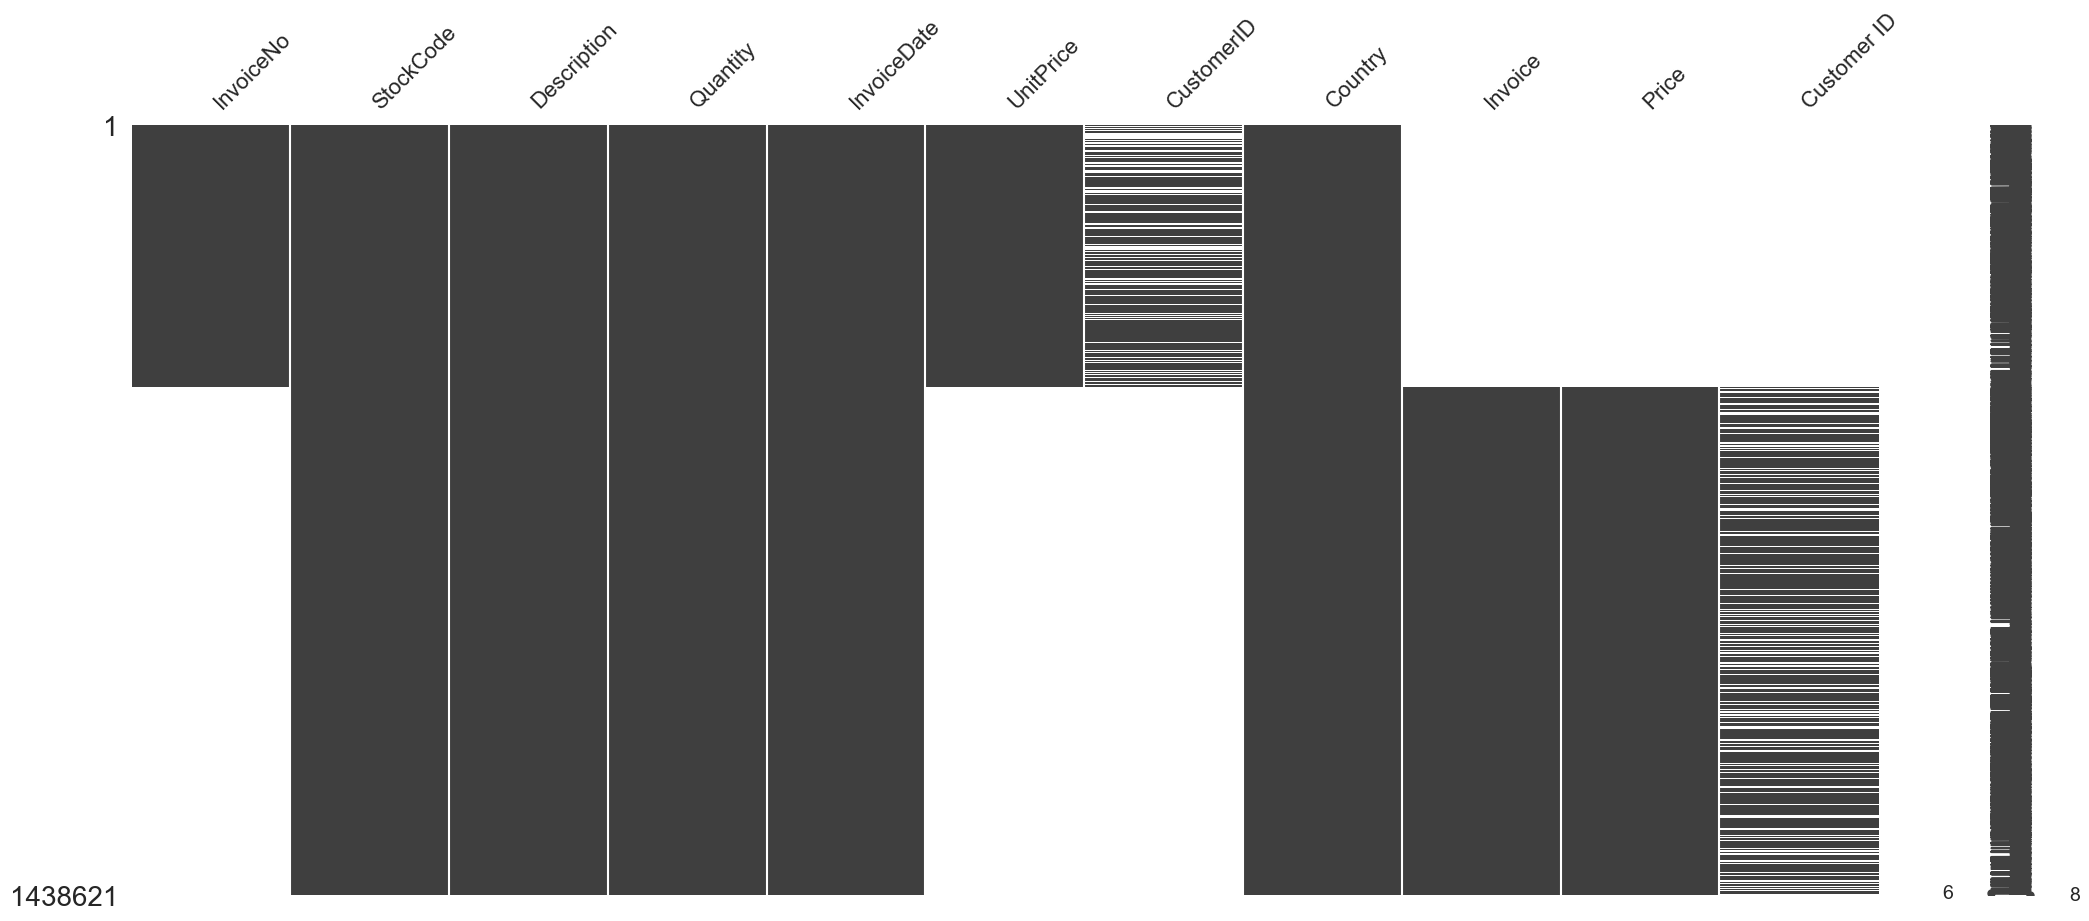


Missing values in Marketing Campaign:
Income    24
dtype: int64
Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase2\missing_matrix_campaign.png


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

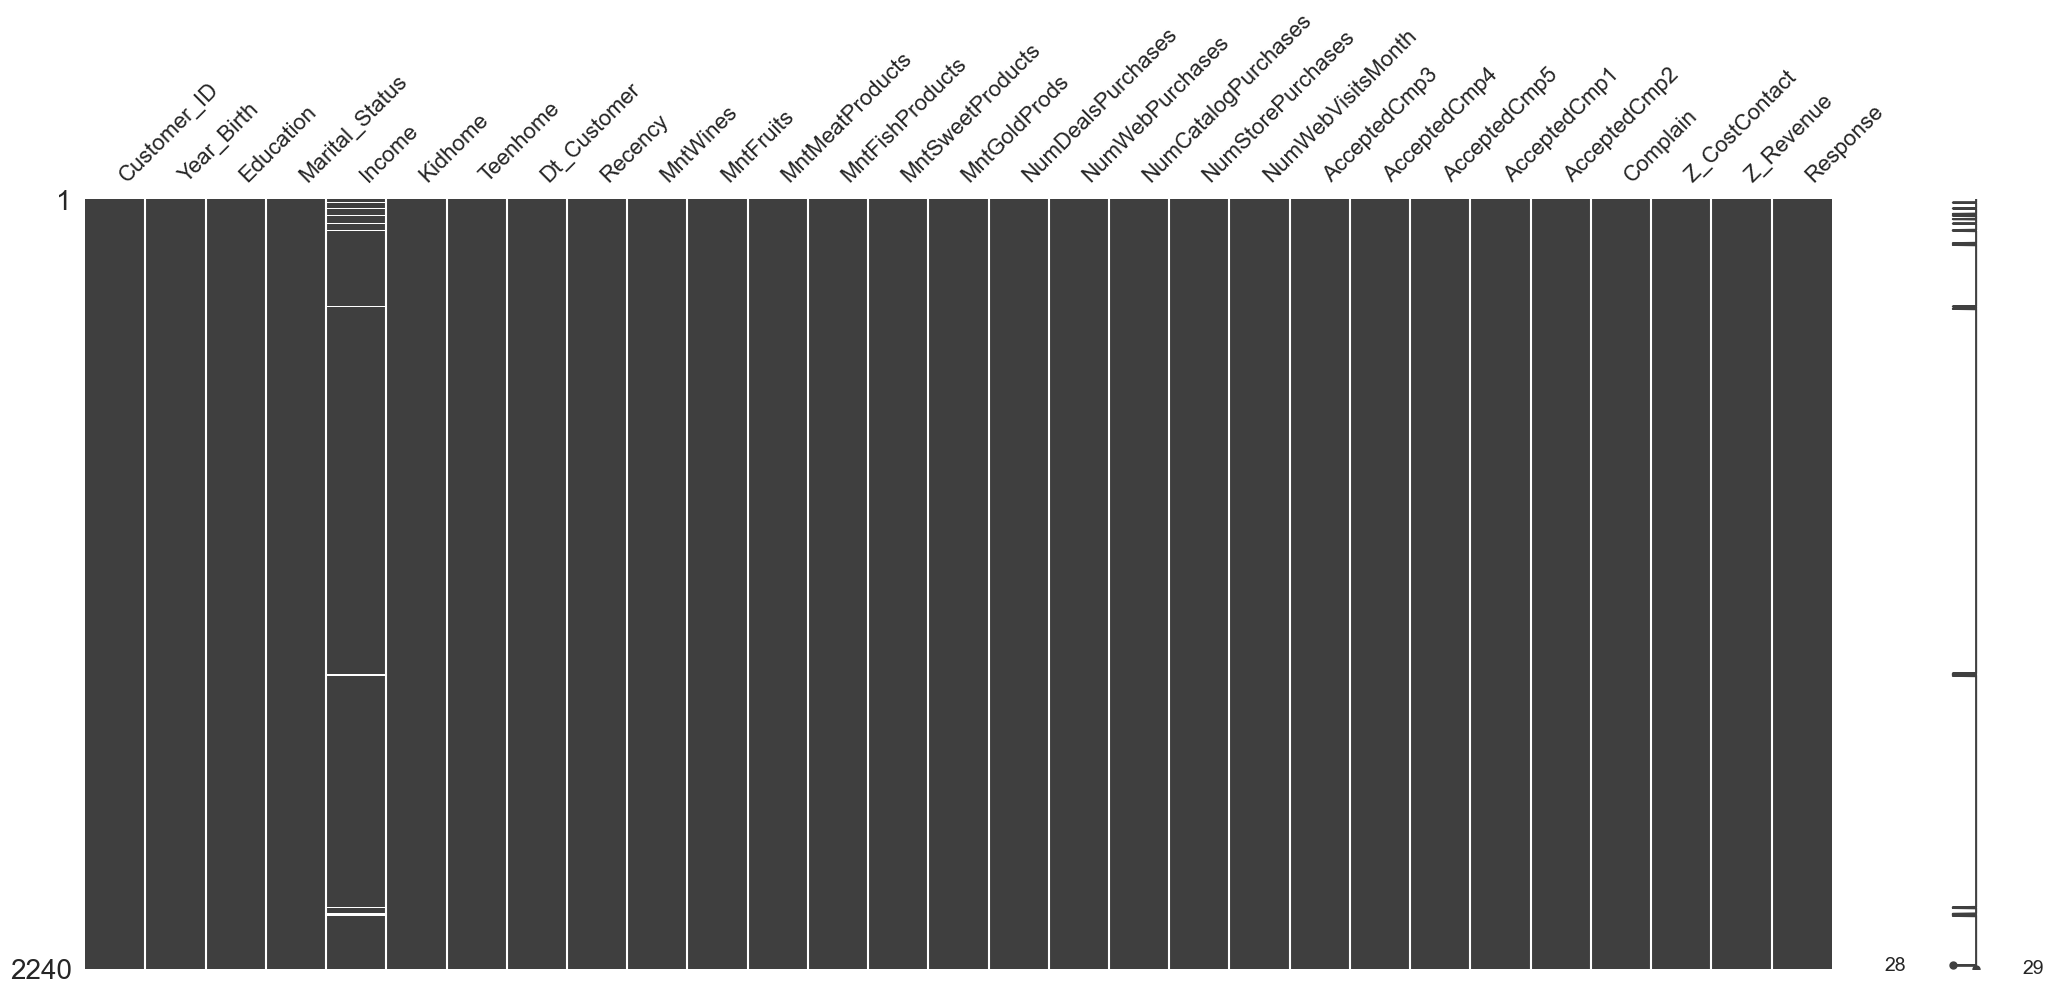

Missing values handled in both datasets.


<Figure size 1000x600 with 0 Axes>

In [8]:
import missingno as msno

# Check missing values in Retail
print("Missing values in Retail Combined:")
retail_missing = retail_combined.isnull().sum()
print(retail_missing[retail_missing > 0])

# Visualize missing values in Retail
fig1 = plt.figure()
msno.matrix(retail_combined)
save_figure(fig1, "missing_matrix_retail.png", "Phase2")
plt.show()
plt.clf()

# Drop rows with missing CustomerID
retail_combined = retail_combined.dropna(subset=['CustomerID'])

# Check missing values in Campaign
print("\nMissing values in Marketing Campaign:")
campaign_missing = campaign.isnull().sum()
print(campaign_missing[campaign_missing > 0])

# Visualize missing values in Campaign
fig2 = plt.figure()
msno.matrix(campaign)
save_figure(fig2, "missing_matrix_campaign.png", "Phase2")
plt.show()
plt.clf()

# Drop rows with missing Income
campaign = campaign.dropna(subset=['Income'])

# Reset indexes
retail_combined.reset_index(drop=True, inplace=True)
campaign.reset_index(drop=True, inplace=True)

print("Missing values handled in both datasets.")


## Step 2.2 – Fix Data Types

In [9]:
# Convert InvoiceDate to datetime
retail_combined['InvoiceDate'] = pd.to_datetime(retail_combined['InvoiceDate'])

# Convert CustomerID to string
retail_combined['CustomerID'] = retail_combined['CustomerID'].astype(str)

# Fix campaign date columns
date_cols = ['Dt_Customer']  # You can add more if applicable
for col in date_cols:
    campaign[col] = pd.to_datetime(campaign[col], errors='coerce')

# Convert Customer_ID to string
campaign['Customer_ID'] = campaign['Customer_ID'].astype(str)

print("Data types fixed successfully.")


Data types fixed successfully.


In [10]:
print(retail_combined[['InvoiceDate', 'CustomerID']].dtypes)
print(campaign[['Dt_Customer', 'Customer_ID']].dtypes)


InvoiceDate    datetime64[ns]
CustomerID             object
dtype: object
Dt_Customer    datetime64[ns]
Customer_ID            object
dtype: object


## Step 2.3 – Remove Outliers (IQR Method)

In [11]:
# Define the IQR remover
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

# Define the print+remove function
def print_outlier_removal_summary(df, column, label):
    original_count = df.shape[0]
    original_stats = df[column].describe()

    df_cleaned = remove_outliers_iqr(df, column)
    cleaned_count = df_cleaned.shape[0]
    cleaned_stats = df_cleaned[column].describe()

    print(f"\n{label} - Outlier Removal Summary ({column}):")
    print(f"Rows before: {original_count}")
    print(f"Rows after : {cleaned_count}")
    print(f"Removed    : {original_count - cleaned_count}")
    print("\nBefore:\n", original_stats)
    print("\nAfter:\n", cleaned_stats)

    return df_cleaned

# Call it to see output
retail_combined = print_outlier_removal_summary(retail_combined, 'Quantity', 'Retail Data')
retail_combined = print_outlier_removal_summary(retail_combined, 'UnitPrice', 'Retail Data')
campaign = print_outlier_removal_summary(campaign, 'Income', 'Campaign Data')



Retail Data - Outlier Removal Summary (Quantity):
Rows before: 356728
Rows after : 335642
Removed    : 21086

Before:
 count    356728.000000
mean         11.198644
std         264.998044
min      -80995.000000
25%           2.000000
50%           4.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

After:
 count    335642.000000
mean          6.574439
std           6.667189
min         -13.000000
25%           2.000000
50%           4.000000
75%          10.000000
max          27.000000
Name: Quantity, dtype: float64

Retail Data - Outlier Removal Summary (UnitPrice):
Rows before: 335642
Rows after : 305556
Removed    : 30086

Before:
 count    335642.000000
mean          3.380833
std          73.352700
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max       38970.000000
Name: UnitPrice, dtype: float64

After:
 count    305556.000000
mean          2.199504
std           1.551108
min           0.000000
25%

## Step 2.4 – Skewness Correction

In [12]:
# Step: Skewness Correction for Income in Marketing Campaign Data

# Show summary stats before transformation
print("Before log1p transformation:")
print(campaign['Income'].describe())

# Apply log1p transformation
campaign['Income_log'] = np.log1p(campaign['Income'])

# Show summary stats after transformation
print("\nAfter log1p transformation:")
print(campaign['Income_log'].describe())


Before log1p transformation:
count      2208.000000
mean      51633.638134
std       20713.376530
min        1730.000000
25%       35196.000000
50%       51301.000000
75%       68289.750000
max      113734.000000
Name: Income, dtype: float64

After log1p transformation:
count    2208.000000
mean       10.748765
std         0.498887
min         7.456455
25%        10.468716
50%        10.845485
75%        11.131530
max        11.641626
Name: Income_log, dtype: float64


## Step 2.5 – Visual EDA + Save PNGs

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase2\income_distribution_log_compare.png


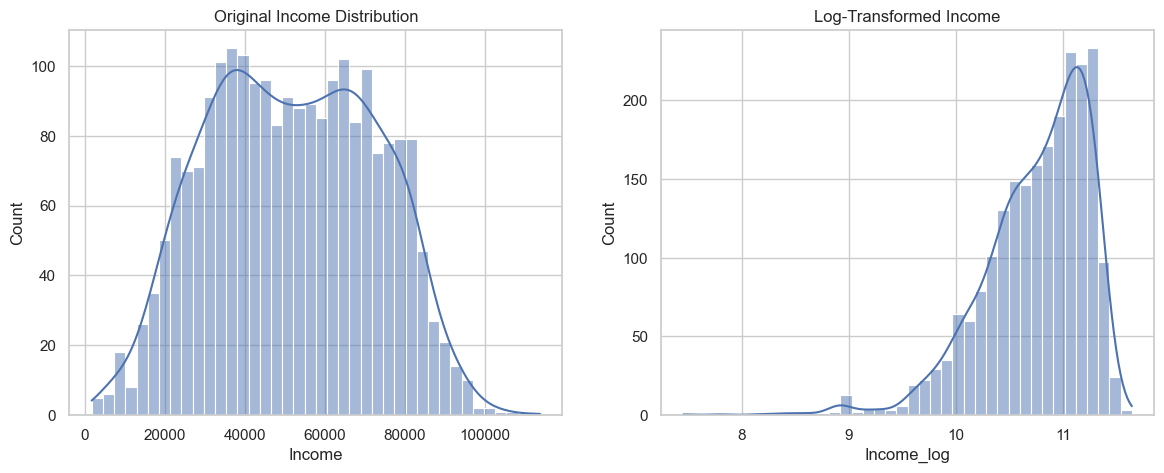

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase2\boxplots_quantity_price.png


<Figure size 1000x600 with 0 Axes>

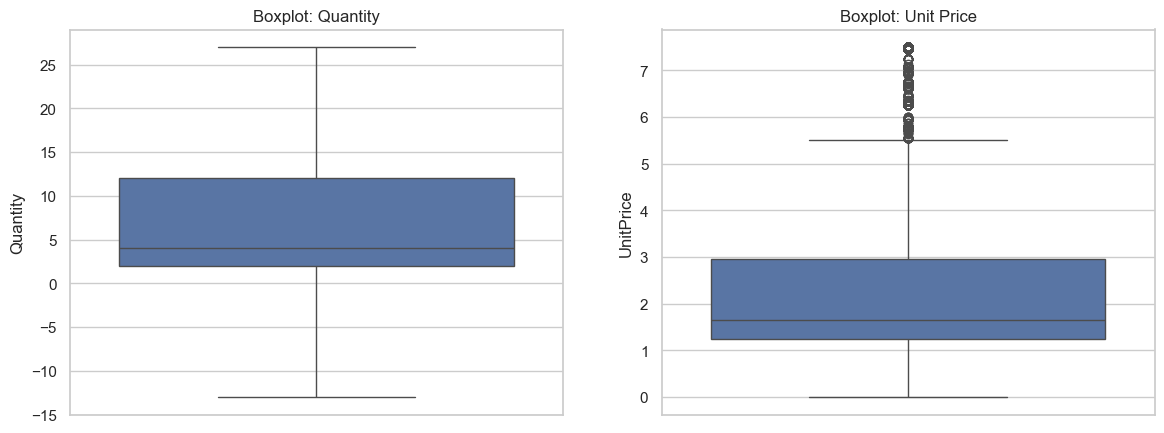

<Figure size 1000x600 with 0 Axes>

In [13]:
# Histogram of Income (before and after log)
fig3, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(campaign['Income'], bins=40, ax=ax[0], kde=True)
ax[0].set_title('Original Income Distribution')
sns.histplot(campaign['Income_log'], bins=40, ax=ax[1], kde=True)
ax[1].set_title('Log-Transformed Income')
save_figure(fig3, "income_distribution_log_compare.png", "Phase2")
plt.show()
plt.clf()

# Boxplot of Quantity and UnitPrice
fig4, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.boxplot(y=retail_combined['Quantity'], ax=ax[0])
ax[0].set_title("Boxplot: Quantity")
sns.boxplot(y=retail_combined['UnitPrice'], ax=ax[1])
ax[1].set_title("Boxplot: Unit Price")
save_figure(fig4, "boxplots_quantity_price.png", "Phase2")
plt.show()
plt.clf()


## Step 2.6 – Clean Retail (Cancelled Invoices, Refunds)

In [14]:
# Remove cancelled invoices (those starting with 'C')
retail_combined = retail_combined[~retail_combined['InvoiceNo'].astype(str).str.startswith('C')]

# Remove records with non-positive quantities or prices
retail_combined = retail_combined[(retail_combined['Quantity'] > 0) & (retail_combined['UnitPrice'] > 0)]

# Reset index after cleanup
retail_combined.reset_index(drop=True, inplace=True)

print("Retail transactions cleaned: cancellations, refunds, invalid values removed.")


Retail transactions cleaned: cancellations, refunds, invalid values removed.


# PHASE 3: Feature Engineering

## Step 3.1 – RFM + AOV (Recency, Frequency, Monetary, Average Order Value)

In [15]:
from datetime import timedelta

# Create 'TotalPrice' for each transaction
retail_combined['TotalPrice'] = retail_combined['Quantity'] * retail_combined['UnitPrice']

# Set snapshot date as 1 day after the latest transaction
snapshot_date = retail_combined['InvoiceDate'].max() + timedelta(days=1)
print(f"Snapshot Date (Reference Point): {snapshot_date.date()}")

# Calculate RFM metrics per customer using the full data
rfm = retail_combined.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency (unique purchase events)
    'TotalPrice': 'sum'                                       # Monetary (total spend)
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Calculate Average Order Value
rfm['AOV'] = rfm['Monetary'] / rfm['Frequency']

# Show preview
print("\nSample of RFM + AOV Features:")
print(rfm.head())

print("\nSummary Statistics:")
print(rfm.describe())

# Save output
rfm_path = os.path.join(project_root, "Processed", "rfm_features.csv")
rfm.to_csv(rfm_path, index=False)
print(f"\nRFM + AOV features saved to: {rfm_path}")


Snapshot Date (Reference Point): 2011-12-10

Sample of RFM + AOV Features:
  CustomerID  Recency  Frequency  Monetary         AOV
0    12747.0        2         11   2640.41  240.037273
1    12748.0        1        196  20519.88  104.693265
2    12749.0        4          5   2737.73  547.546000
3    12820.0        3          4    923.62  230.905000
4    12821.0      214          1     75.72   75.720000

Summary Statistics:
           Recency    Frequency      Monetary          AOV
count  3784.000000  3784.000000   3784.000000  3784.000000
mean     91.797304     4.002114    972.777342   234.381068
std      99.183313     6.521077   1766.443951   173.899488
min       1.000000     1.000000      1.900000     1.900000
25%      18.000000     1.000000    200.202500   123.849643
50%      50.000000     2.000000    449.675000   197.760000
75%     143.000000     4.000000   1091.532500   299.697500
max     374.000000   196.000000  36347.880000  2292.000000

RFM + AOV features saved to: CustomerSegme

### Visualize the distribution of RFM + AOV metrics

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase3\rfm_aov_distributions.png


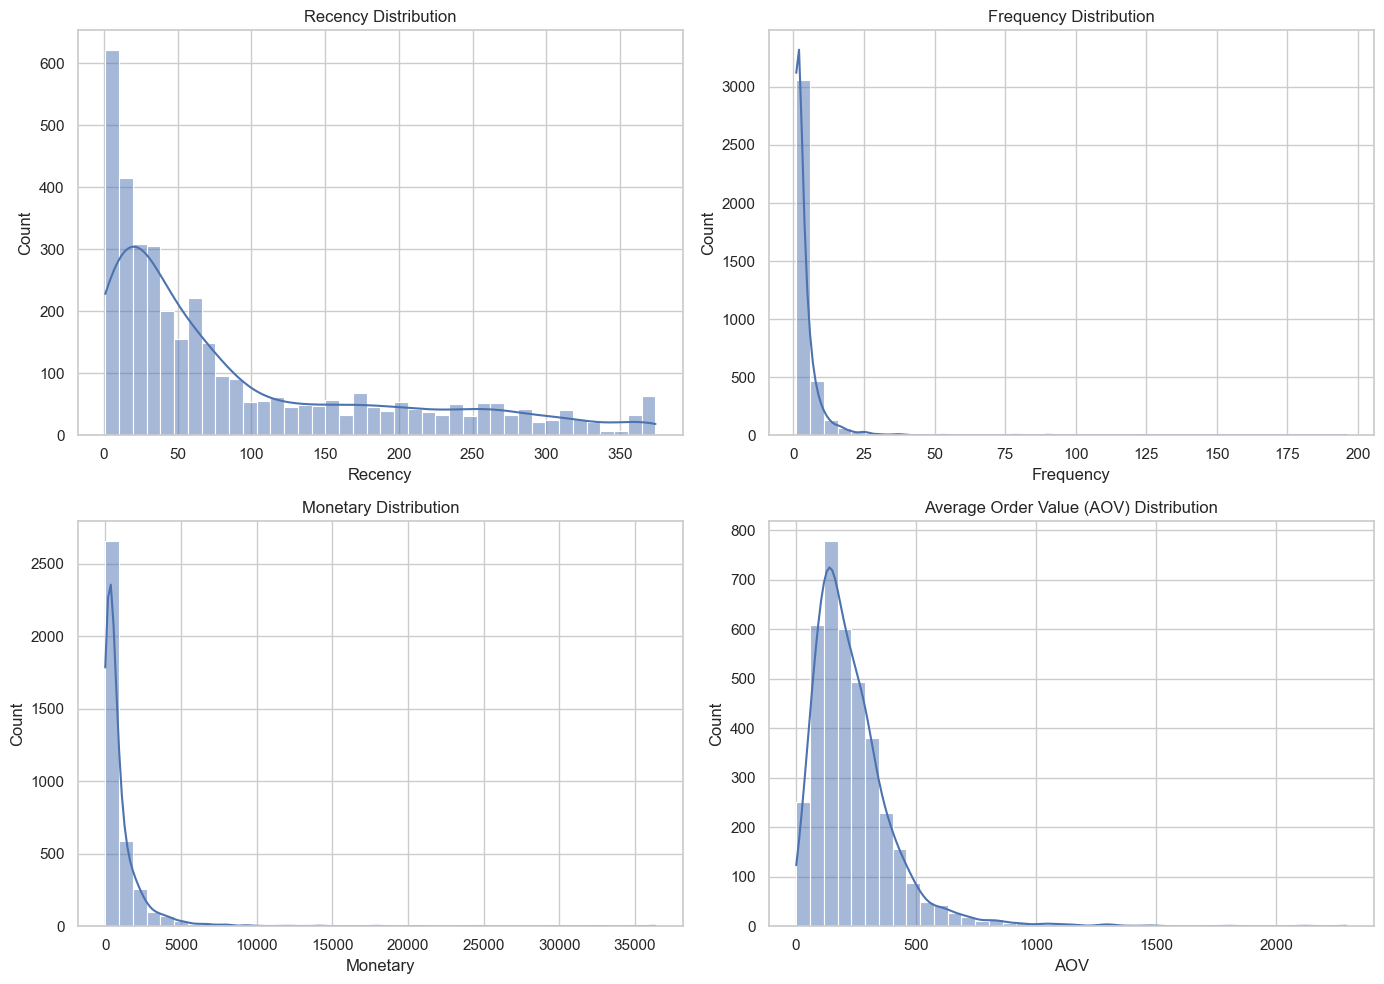

<Figure size 1000x600 with 0 Axes>

In [16]:
# Visualize the distribution of RFM + AOV metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.histplot(rfm['Recency'], bins=40, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Recency Distribution")

sns.histplot(rfm['Frequency'], bins=40, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Frequency Distribution")

sns.histplot(rfm['Monetary'], bins=40, kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Monetary Distribution")

sns.histplot(rfm['AOV'], bins=40, kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Average Order Value (AOV) Distribution")

plt.tight_layout()
save_figure(fig, "rfm_aov_distributions.png", "Phase3")
plt.show()
plt.clf()


### Compare Skewness of Monetary Before and After Log Transform

Skewness before log1p: 8.77
Skewness after log1p:  -0.10
Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase3\monetary_skewness_comparison.png


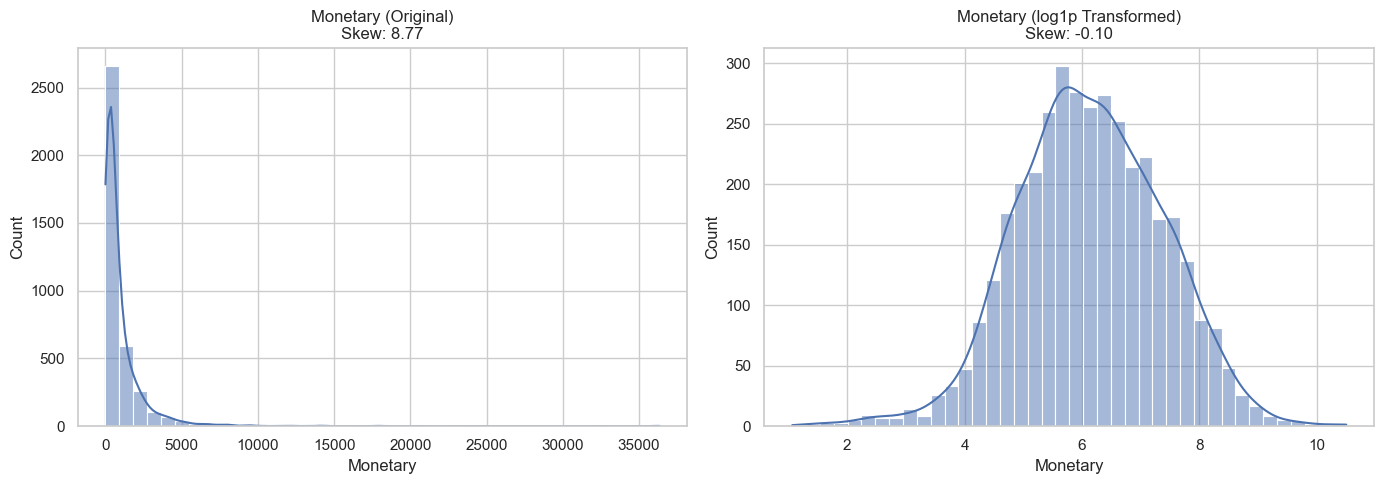

<Figure size 1000x600 with 0 Axes>

In [17]:
from scipy.stats import skew

# Calculate and print skewness values
monetary_skew_before = skew(rfm['Monetary'])
monetary_skew_after = skew(np.log1p(rfm['Monetary']))

print(f"Skewness before log1p: {monetary_skew_before:.2f}")
print(f"Skewness after log1p:  {monetary_skew_after:.2f}")

# Plot histograms for comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(rfm['Monetary'], bins=40, kde=True, ax=axes[0])
axes[0].set_title(f"Monetary (Original)\nSkew: {monetary_skew_before:.2f}")

sns.histplot(np.log1p(rfm['Monetary']), bins=40, kde=True, ax=axes[1])
axes[1].set_title(f"Monetary (log1p Transformed)\nSkew: {monetary_skew_after:.2f}")

plt.tight_layout()
save_figure(fig, "monetary_skewness_comparison.png", "Phase3")
plt.show()
plt.clf()


## Step 3.2 – Churn Labeling

In [18]:
# Define cutoff threshold in days
churn_cutoff_days = 90

# Label churn: 1 if Recency >= 90 days, else 0
rfm['Churned'] = (rfm['Recency'] >= churn_cutoff_days).astype(int)

# Preview churn labels
print("\nSample Churn Labeling:")
print(rfm[['CustomerID', 'Recency', 'Churned']].head(10))

# Churn distribution summary
print("\nChurn Distribution:")
print(rfm['Churned'].value_counts())
print(rfm['Churned'].value_counts(normalize=True).map("{:.2%}".format))


Sample Churn Labeling:
  CustomerID  Recency  Churned
0    12747.0        2        0
1    12748.0        1        0
2    12749.0        4        0
3    12820.0        3        0
4    12821.0      214        1
5    12822.0       71        0
6    12824.0       60        0
7    12826.0        3        0
8    12827.0        6        0
9    12828.0        3        0

Churn Distribution:
Churned
0    2531
1    1253
Name: count, dtype: int64
Churned
0    66.89%
1    33.11%
Name: proportion, dtype: object


### Churn Visualization

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase3\churn_distribution.png


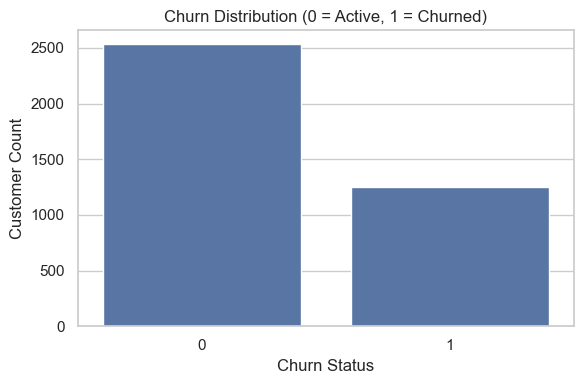

<Figure size 1000x600 with 0 Axes>

In [19]:
# Bar plot: churn vs active customers
fig = plt.figure(figsize=(6, 4))
sns.countplot(x='Churned', data=rfm)
plt.title("Churn Distribution (0 = Active, 1 = Churned)")
plt.xlabel("Churn Status")
plt.ylabel("Customer Count")
plt.tight_layout()
save_figure(fig, "churn_distribution.png", "Phase3")
plt.show()
plt.clf()


### Save Updated RFM with Churn

In [20]:
# Save churn-labeled RFM dataset
rfm_churn_path = os.path.join(project_root, "Processed", "rfm_with_churn.csv")
rfm.to_csv(rfm_churn_path, index=False)
print(f"Churn-labeled RFM data saved to: {rfm_churn_path}")


Churn-labeled RFM data saved to: CustomerSegmentAI360\Processed\rfm_with_churn.csv


## Step 3.3 – Customer Lifetime Value (CLV) Calculation

In [21]:
# Assumed average gross margin percentage (e.g., 10%)
margin_rate = 0.10

# Calculate simple CLV
rfm['CLV'] = margin_rate * rfm['Frequency'] * rfm['AOV']

# Preview sample
print("\nSample of CLV values:")
print(rfm[['CustomerID', 'Frequency', 'AOV', 'CLV']].head(10))

# Summary statistics
print("\nCLV Summary Statistics:")
print(rfm['CLV'].describe())


Sample of CLV values:
  CustomerID  Frequency         AOV       CLV
0    12747.0         11  240.037273   264.041
1    12748.0        196  104.693265  2051.988
2    12749.0          5  547.546000   273.773
3    12820.0          4  230.905000    92.362
4    12821.0          1   75.720000     7.572
5    12822.0          2  371.640000    74.328
6    12824.0          1  316.420000    31.642
7    12826.0          7  208.685714   146.080
8    12827.0          3  143.383333    43.015
9    12828.0          6  160.326667    96.196

CLV Summary Statistics:
count    3784.000000
mean       97.277734
std       176.644395
min         0.190000
25%        20.020250
50%        44.967500
75%       109.153250
max      3634.788000
Name: CLV, dtype: float64


### Visualization: CLV Distribution

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase3\clv_distribution.png


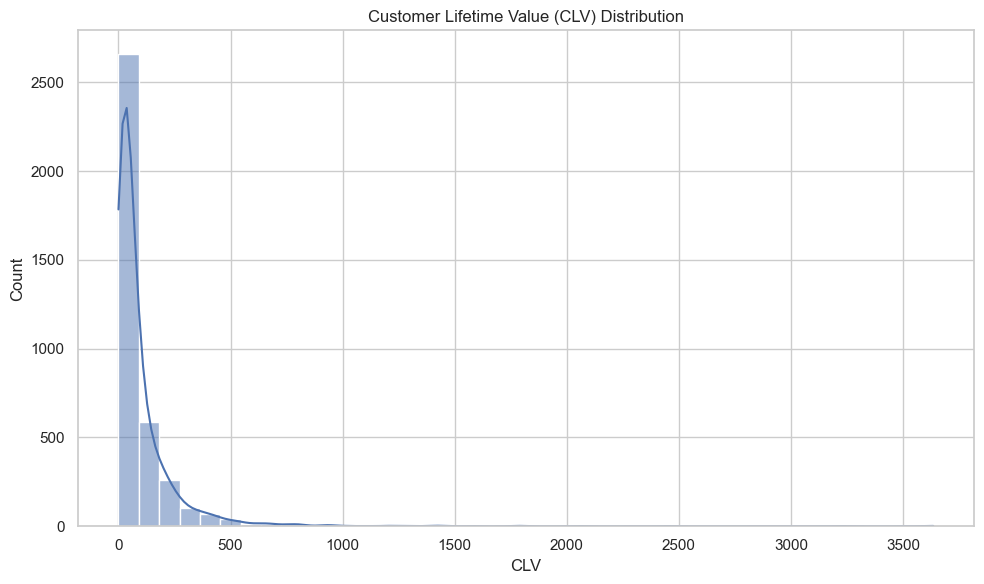

<Figure size 1000x600 with 0 Axes>

In [22]:
# Visualize CLV distribution
fig = plt.figure(figsize=(10, 6))
sns.histplot(rfm['CLV'], bins=40, kde=True)
plt.title("Customer Lifetime Value (CLV) Distribution")
plt.tight_layout()
save_figure(fig, "clv_distribution.png", "Phase3")
plt.show()
plt.clf()


### Save Updated RFM with CLV

In [23]:
# Save updated RFM data with CLV
rfm_clv_path = os.path.join(project_root, "Processed", "rfm_with_clv.csv")
rfm.to_csv(rfm_clv_path, index=False)
print(f"CLV data saved to: {rfm_clv_path}")


CLV data saved to: CustomerSegmentAI360\Processed\rfm_with_clv.csv


## Step 3.4 – Loyalty Duration & Tenure

In [24]:
# Group by CustomerID and get first and last purchase dates
tenure_df = retail_combined.groupby('CustomerID').agg({
    'InvoiceDate': ['min', 'max']
}).reset_index()

# Flatten MultiIndex columns
tenure_df.columns = ['CustomerID', 'FirstPurchaseDate', 'LastPurchaseDate']

# Calculate tenure in days
tenure_df['Tenure'] = (tenure_df['LastPurchaseDate'] - tenure_df['FirstPurchaseDate']).dt.days

# Merge tenure info into RFM table
rfm = rfm.merge(tenure_df[['CustomerID', 'Tenure']], on='CustomerID', how='left')

# Preview
print("\nSample Tenure Info:")
print(rfm[['CustomerID', 'Recency', 'Frequency', 'Tenure']].head(10))

# Summary statistics
print("\nTenure Summary Statistics:")
print(rfm['Tenure'].describe())



Sample Tenure Info:
  CustomerID  Recency  Frequency  Tenure
0    12747.0        2         11     366
1    12748.0        1        196     372
2    12749.0        4          5     209
3    12820.0        3          4     323
4    12821.0      214          1       0
5    12822.0       71          2      16
6    12824.0       60          1       0
7    12826.0        3          7     362
8    12827.0        6          3      38
9    12828.0        3          6     127

Tenure Summary Statistics:
count    3784.000000
mean      129.296512
std       131.639421
min         0.000000
25%         0.000000
50%        90.000000
75%       250.000000
max       373.000000
Name: Tenure, dtype: float64


### Visualization: Tenure Distribution

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase3\tenure_distribution.png


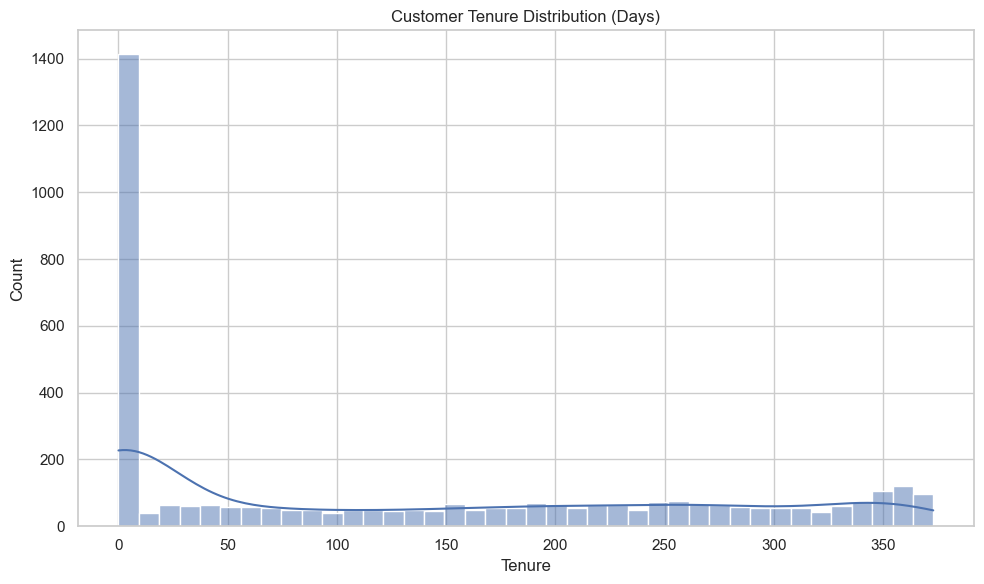

<Figure size 1000x600 with 0 Axes>

In [25]:
# Histogram of customer tenure
fig = plt.figure(figsize=(10, 6))
sns.histplot(rfm['Tenure'], bins=40, kde=True)
plt.title("Customer Tenure Distribution (Days)")
plt.tight_layout()
save_figure(fig, "tenure_distribution.png", "Phase3")
plt.show()
plt.clf()


### Save Updated Data with Tenure

In [26]:
# Save updated RFM with tenure
rfm_tenure_path = os.path.join(project_root, "Processed", "rfm_with_tenure.csv")
rfm.to_csv(rfm_tenure_path, index=False)
print(f"Loyalty duration (tenure) added. File saved to: {rfm_tenure_path}")


Loyalty duration (tenure) added. File saved to: CustomerSegmentAI360\Processed\rfm_with_tenure.csv


## Step 3.5 – Category-Based Behavior

In [27]:
# Copy of retail_combined to avoid mutation
df = retail_combined.copy()

# Count unique products bought per customer
product_behavior = df.groupby('CustomerID').agg(
    UniqueProducts=('StockCode', 'nunique')
).reset_index()

# Identify the most purchased product (by quantity) per customer
top_product = df.groupby(['CustomerID', 'StockCode']).agg(
    TotalQuantity=('Quantity', 'sum')
).reset_index()

# Get each customer's top product by quantity
top_product = top_product.sort_values(['CustomerID', 'TotalQuantity'], ascending=[True, False])
top_product = top_product.drop_duplicates('CustomerID', keep='first')

# Optional: merge product descriptions for interpretability
top_product = top_product.merge(df[['StockCode', 'Description']].drop_duplicates(), on='StockCode', how='left')

# Finalize columns
top_product = top_product[['CustomerID', 'StockCode', 'Description', 'TotalQuantity']]
top_product.columns = ['CustomerID', 'TopProductCode', 'TopProductDesc', 'TopProductQuantity']

# Merge both into the RFM table
rfm = rfm.merge(product_behavior, on='CustomerID', how='left')
rfm = rfm.merge(top_product, on='CustomerID', how='left')

# Preview sample
print("\nSample Product Behavior Features:")
print(rfm[['CustomerID', 'UniqueProducts', 'TopProductCode', 'TopProductQuantity', 'TopProductDesc']].head(10))



Sample Product Behavior Features:
  CustomerID  UniqueProducts TopProductCode  TopProductQuantity  \
0    12747.0              32         82494L                 120   
1    12748.0            1597          22197                 147   
2    12748.0            1597          22197                 147   
3    12749.0             120          23307                  48   
4    12820.0              54          21498                  25   
5    12821.0               5          22335                  24   
6    12822.0              37          22417                  24   
7    12824.0              22          23271                  16   
8    12824.0              22          23271                  16   
9    12826.0              57          20978                  48   

                        TopProductDesc  
0          WOODEN FRAME ANTIQUE WHITE   
1                 SMALL POPCORN HOLDER  
2                       POPCORN HOLDER  
3  SET OF 60 PANTRY DESIGN CAKE CASES   
4                  RED

### Unique Products per Customer

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase3\unique_products_per_customer.png


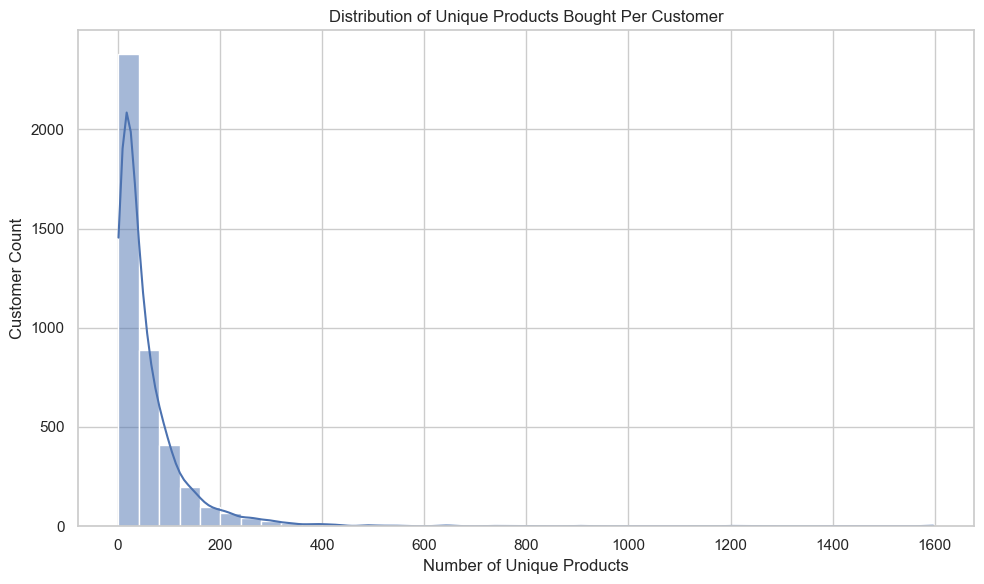

<Figure size 1000x600 with 0 Axes>

In [28]:
# Distribution: number of unique products bought
fig1 = plt.figure(figsize=(10, 6))
sns.histplot(rfm['UniqueProducts'], bins=40, kde=True)
plt.title("Distribution of Unique Products Bought Per Customer")
plt.xlabel("Number of Unique Products")
plt.ylabel("Customer Count")
plt.tight_layout()
save_figure(fig1, "unique_products_per_customer.png", "Phase3")
plt.show()
plt.clf()


### Top 10 Most Purchased Products (by Total Quantity)

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase3\top_products_by_quantity.png


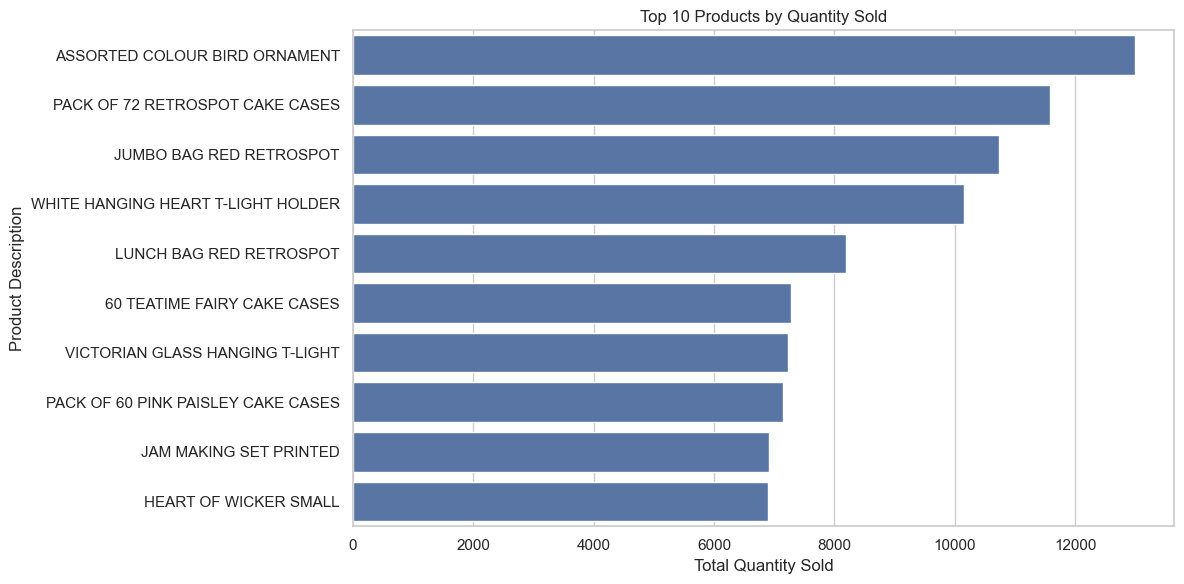

<Figure size 1000x600 with 0 Axes>

In [29]:
# Group and sort products by total quantity sold
top_quantity = retail_combined.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

fig2 = plt.figure(figsize=(12, 6))
sns.barplot(x=top_quantity.values, y=top_quantity.index)
plt.title("Top 10 Products by Quantity Sold")
plt.xlabel("Total Quantity Sold")
plt.ylabel("Product Description")
plt.tight_layout()
save_figure(fig2, "top_products_by_quantity.png", "Phase3")
plt.show()
plt.clf()


### Top 10 Most Popular Products (by Customer Count)

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase3\top_products_by_customers.png


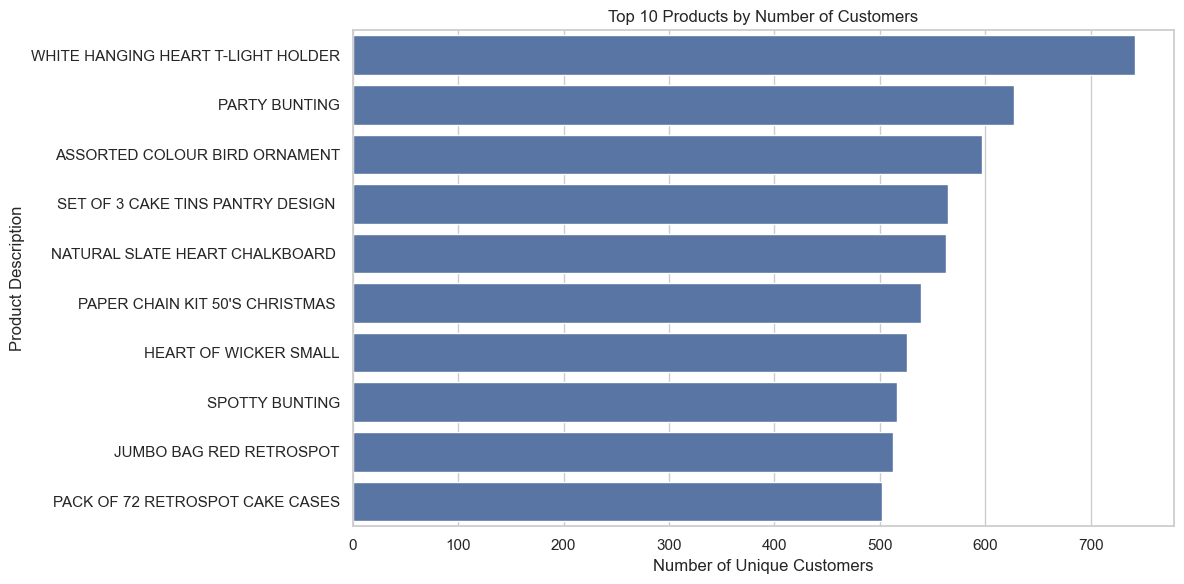

<Figure size 1000x600 with 0 Axes>

In [30]:
# Count how many unique customers bought each product
top_customers = retail_combined.groupby('Description')['CustomerID'].nunique().sort_values(ascending=False).head(10)

fig3 = plt.figure(figsize=(12, 6))
sns.barplot(x=top_customers.values, y=top_customers.index)
plt.title("Top 10 Products by Number of Customers")
plt.xlabel("Number of Unique Customers")
plt.ylabel("Product Description")
plt.tight_layout()
save_figure(fig3, "top_products_by_customers.png", "Phase3")
plt.show()
plt.clf()


### Save Updated Dataset

In [31]:
# Save enriched RFM with product behavior
rfm_product_path = os.path.join(project_root, "Processed", "rfm_with_product_behavior.csv")
rfm.to_csv(rfm_product_path, index=False)
print(f"Product behavior features added. File saved to: {rfm_product_path}")


Product behavior features added. File saved to: CustomerSegmentAI360\Processed\rfm_with_product_behavior.csv


## Step 3.6 – Engagement Score & Session Metrics

In [32]:
# Average Basket Size = Total Quantity per customer / total number of invoices
basket_size_df = retail_combined.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',
    'Quantity': 'sum',
    'TotalPrice': 'sum'
}).reset_index()

basket_size_df.columns = ['CustomerID', 'SessionCount', 'TotalQuantity', 'TotalSpend']

# Calculate Avg Basket Size per session
basket_size_df['AvgBasketSize'] = basket_size_df['TotalQuantity'] / basket_size_df['SessionCount']

# Calculate Avg Order Value (per invoice)
basket_size_df['AvgOrderValue'] = basket_size_df['TotalSpend'] / basket_size_df['SessionCount']

# Normalize values using min-max scaling for fair combination
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(basket_size_df[['AvgBasketSize', 'AvgOrderValue', 'SessionCount']])
basket_size_df['EngagementScore'] = scaled_features.mean(axis=1)

# Drop intermediary columns before merging
engagement_features = basket_size_df[['CustomerID', 'AvgBasketSize', 'AvgOrderValue', 'SessionCount', 'EngagementScore']]

# Merge into RFM dataset
rfm = rfm.merge(engagement_features, on='CustomerID', how='left')

# Preview
print("\nSample Engagement Metrics:")
print(rfm[['CustomerID', 'AvgBasketSize', 'AvgOrderValue', 'SessionCount', 'EngagementScore']].head())



Sample Engagement Metrics:
  CustomerID  AvgBasketSize  AvgOrderValue  SessionCount  EngagementScore
0    12747.0      87.909091     240.037273            11         0.074693
1    12748.0      76.750000     104.693265           196         0.368287
2    12748.0      76.750000     104.693265           196         0.368287
3    12749.0     245.000000     547.546000             5         0.150656
4    12820.0     168.500000     230.905000             4         0.082668


### Visualization 

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase3\engagement_score_distribution.png


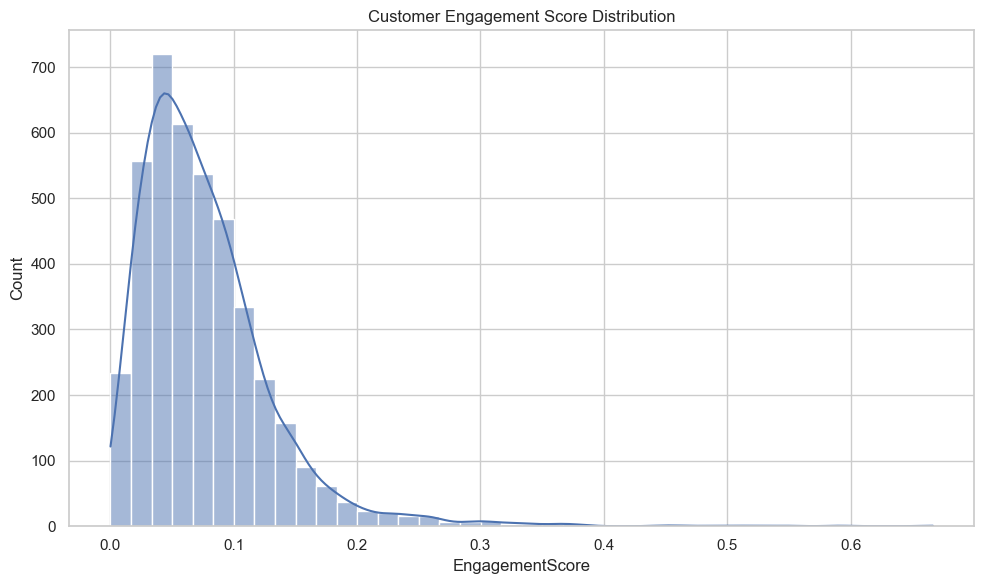

<Figure size 1000x600 with 0 Axes>

In [33]:
# Visualize Engagement Score
fig = plt.figure(figsize=(10, 6))
sns.histplot(rfm['EngagementScore'], bins=40, kde=True)
plt.title("Customer Engagement Score Distribution")
plt.tight_layout()
save_figure(fig, "engagement_score_distribution.png", "Phase3")
plt.show()
plt.clf()


### Save updated dataset with engagement metrics

In [34]:
# Save updated dataset with engagement metrics
rfm_engagement_path = os.path.join(project_root, "Processed", "rfm_with_engagement.csv")
rfm.to_csv(rfm_engagement_path, index=False)
print(f"Engagement metrics saved to: {rfm_engagement_path}")


Engagement metrics saved to: CustomerSegmentAI360\Processed\rfm_with_engagement.csv


## Step 3.7 – Time-Based Behavior Analysis

In [35]:
# Ensure CustomerID is treated as string in both DataFrames
df['CustomerID'] = df['CustomerID'].astype(str)
rfm['CustomerID'] = rfm['CustomerID'].astype(str)

# Ensure datetime is correctly parsed
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceDateOnly'] = df['InvoiceDate'].dt.date
df['Hour'] = df['InvoiceDate'].dt.hour
df['Weekday'] = df['InvoiceDate'].dt.weekday  # Monday=0, Sunday=6
df['IsWeekend'] = df['Weekday'] >= 5

# 1. Weekend Purchase Ratio per customer
weekend_ratio = df.groupby('CustomerID')['IsWeekend'].mean().reset_index()
weekend_ratio.columns = ['CustomerID', 'WeekendPurchaseRatio']
weekend_ratio['CustomerID'] = weekend_ratio['CustomerID'].astype(str)

# 2. Most frequent purchase hour (peak hour)
peak_hour = df.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
peak_hour = peak_hour.sort_values(['CustomerID', 'Count'], ascending=[True, False])
peak_hour = peak_hour.drop_duplicates('CustomerID', keep='first')[['CustomerID', 'Hour']]
peak_hour.columns = ['CustomerID', 'PeakHour']
peak_hour['CustomerID'] = peak_hour['CustomerID'].astype(str)

# 3. Average days between orders
days_gap_df = df[['CustomerID', 'InvoiceDateOnly']].drop_duplicates()
days_gap_df = days_gap_df.sort_values(['CustomerID', 'InvoiceDateOnly'])
days_gap_df['PrevDate'] = days_gap_df.groupby('CustomerID')['InvoiceDateOnly'].shift(1)
days_gap_df['GapDays'] = (
    pd.to_datetime(days_gap_df['InvoiceDateOnly']) - 
    pd.to_datetime(days_gap_df['PrevDate'])
).dt.days

avg_gap = days_gap_df.groupby('CustomerID')['GapDays'].mean().reset_index()
avg_gap.columns = ['CustomerID', 'AvgDaysBetweenOrders']
avg_gap['CustomerID'] = avg_gap['CustomerID'].astype(str)

# Merge time-based features into RFM safely
rfm = rfm.merge(weekend_ratio, on='CustomerID', how='left')
rfm = rfm.merge(peak_hour, on='CustomerID', how='left')
rfm = rfm.merge(avg_gap, on='CustomerID', how='left')

# Preview sample
print("\nSample Time-Based Features:")
print(rfm[['CustomerID', 'WeekendPurchaseRatio', 'PeakHour', 'AvgDaysBetweenOrders']].head())



Sample Time-Based Features:
  CustomerID  WeekendPurchaseRatio  PeakHour  AvgDaysBetweenOrders
0    12747.0              0.076923        14             36.700000
1    12748.0              0.152249        11              3.422018
2    12748.0              0.152249        11              3.422018
3    12749.0              0.000000        12             70.000000
4    12820.0              0.000000        13            107.666667


### Visualization: Weekend Purchase Ratio

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase3\weekend_purchase_ratio.png


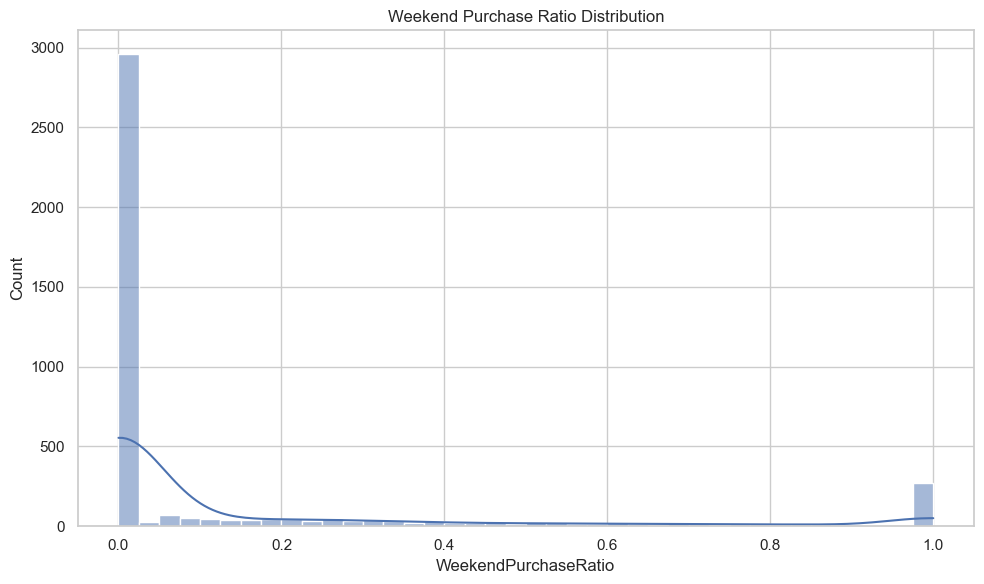

<Figure size 1000x600 with 0 Axes>

In [36]:
# Visualize weekend purchase ratio
fig = plt.figure(figsize=(10, 6))
sns.histplot(rfm['WeekendPurchaseRatio'], bins=40, kde=True)
plt.title("Weekend Purchase Ratio Distribution")
plt.tight_layout()
save_figure(fig, "weekend_purchase_ratio.png", "Phase3")
plt.show()
plt.clf()


In [37]:
# Save enriched data with time-based features
rfm_time_path = os.path.join(project_root, "Processed", "rfm_with_time_features.csv")
rfm.to_csv(rfm_time_path, index=False)
print(f"Time-based features saved to: {rfm_time_path}")


Time-based features saved to: CustomerSegmentAI360\Processed\rfm_with_time_features.csv


##  Step 3.8 – Final Save & Visual Summary

In [38]:
# Show final column names
print("Final feature columns:")
print(rfm.columns.tolist())

# Show data shape
print(f"\nFinal dataset shape: {rfm.shape}")


Final feature columns:
['CustomerID', 'Recency', 'Frequency', 'Monetary', 'AOV', 'Churned', 'CLV', 'Tenure', 'UniqueProducts', 'TopProductCode', 'TopProductDesc', 'TopProductQuantity', 'AvgBasketSize', 'AvgOrderValue', 'SessionCount', 'EngagementScore', 'WeekendPurchaseRatio', 'PeakHour', 'AvgDaysBetweenOrders']

Final dataset shape: (4152, 19)


In [39]:
# Descriptive statistics
print("\nSummary Statistics of Final Features:")
print(rfm.describe())



Summary Statistics of Final Features:
           Recency    Frequency      Monetary          AOV      Churned  \
count  4152.000000  4152.000000   4152.000000  4152.000000  4152.000000   
mean     90.235308     4.139451   1005.999192   234.809974     0.325626   
std      98.328040     7.149036   1823.307184   172.189682     0.468665   
min       1.000000     1.000000      1.900000     1.900000     0.000000   
25%      18.000000     1.000000    203.315000   124.717500     0.000000   
50%      50.000000     2.000000    459.370000   198.994107     0.000000   
75%     137.250000     5.000000   1126.985000   301.466250     1.000000   
max     374.000000   196.000000  36347.880000  2292.000000     1.000000   

               CLV       Tenure  UniqueProducts  TopProductQuantity  \
count  4152.000000  4152.000000     4152.000000         4152.000000   
mean    100.599919   131.828516       56.402938           35.241811   
std     182.330718   132.253467       78.776838           31.549608   
m

### Visual Summary: Histograms of Key Features

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase3\final_feature_distributions.png


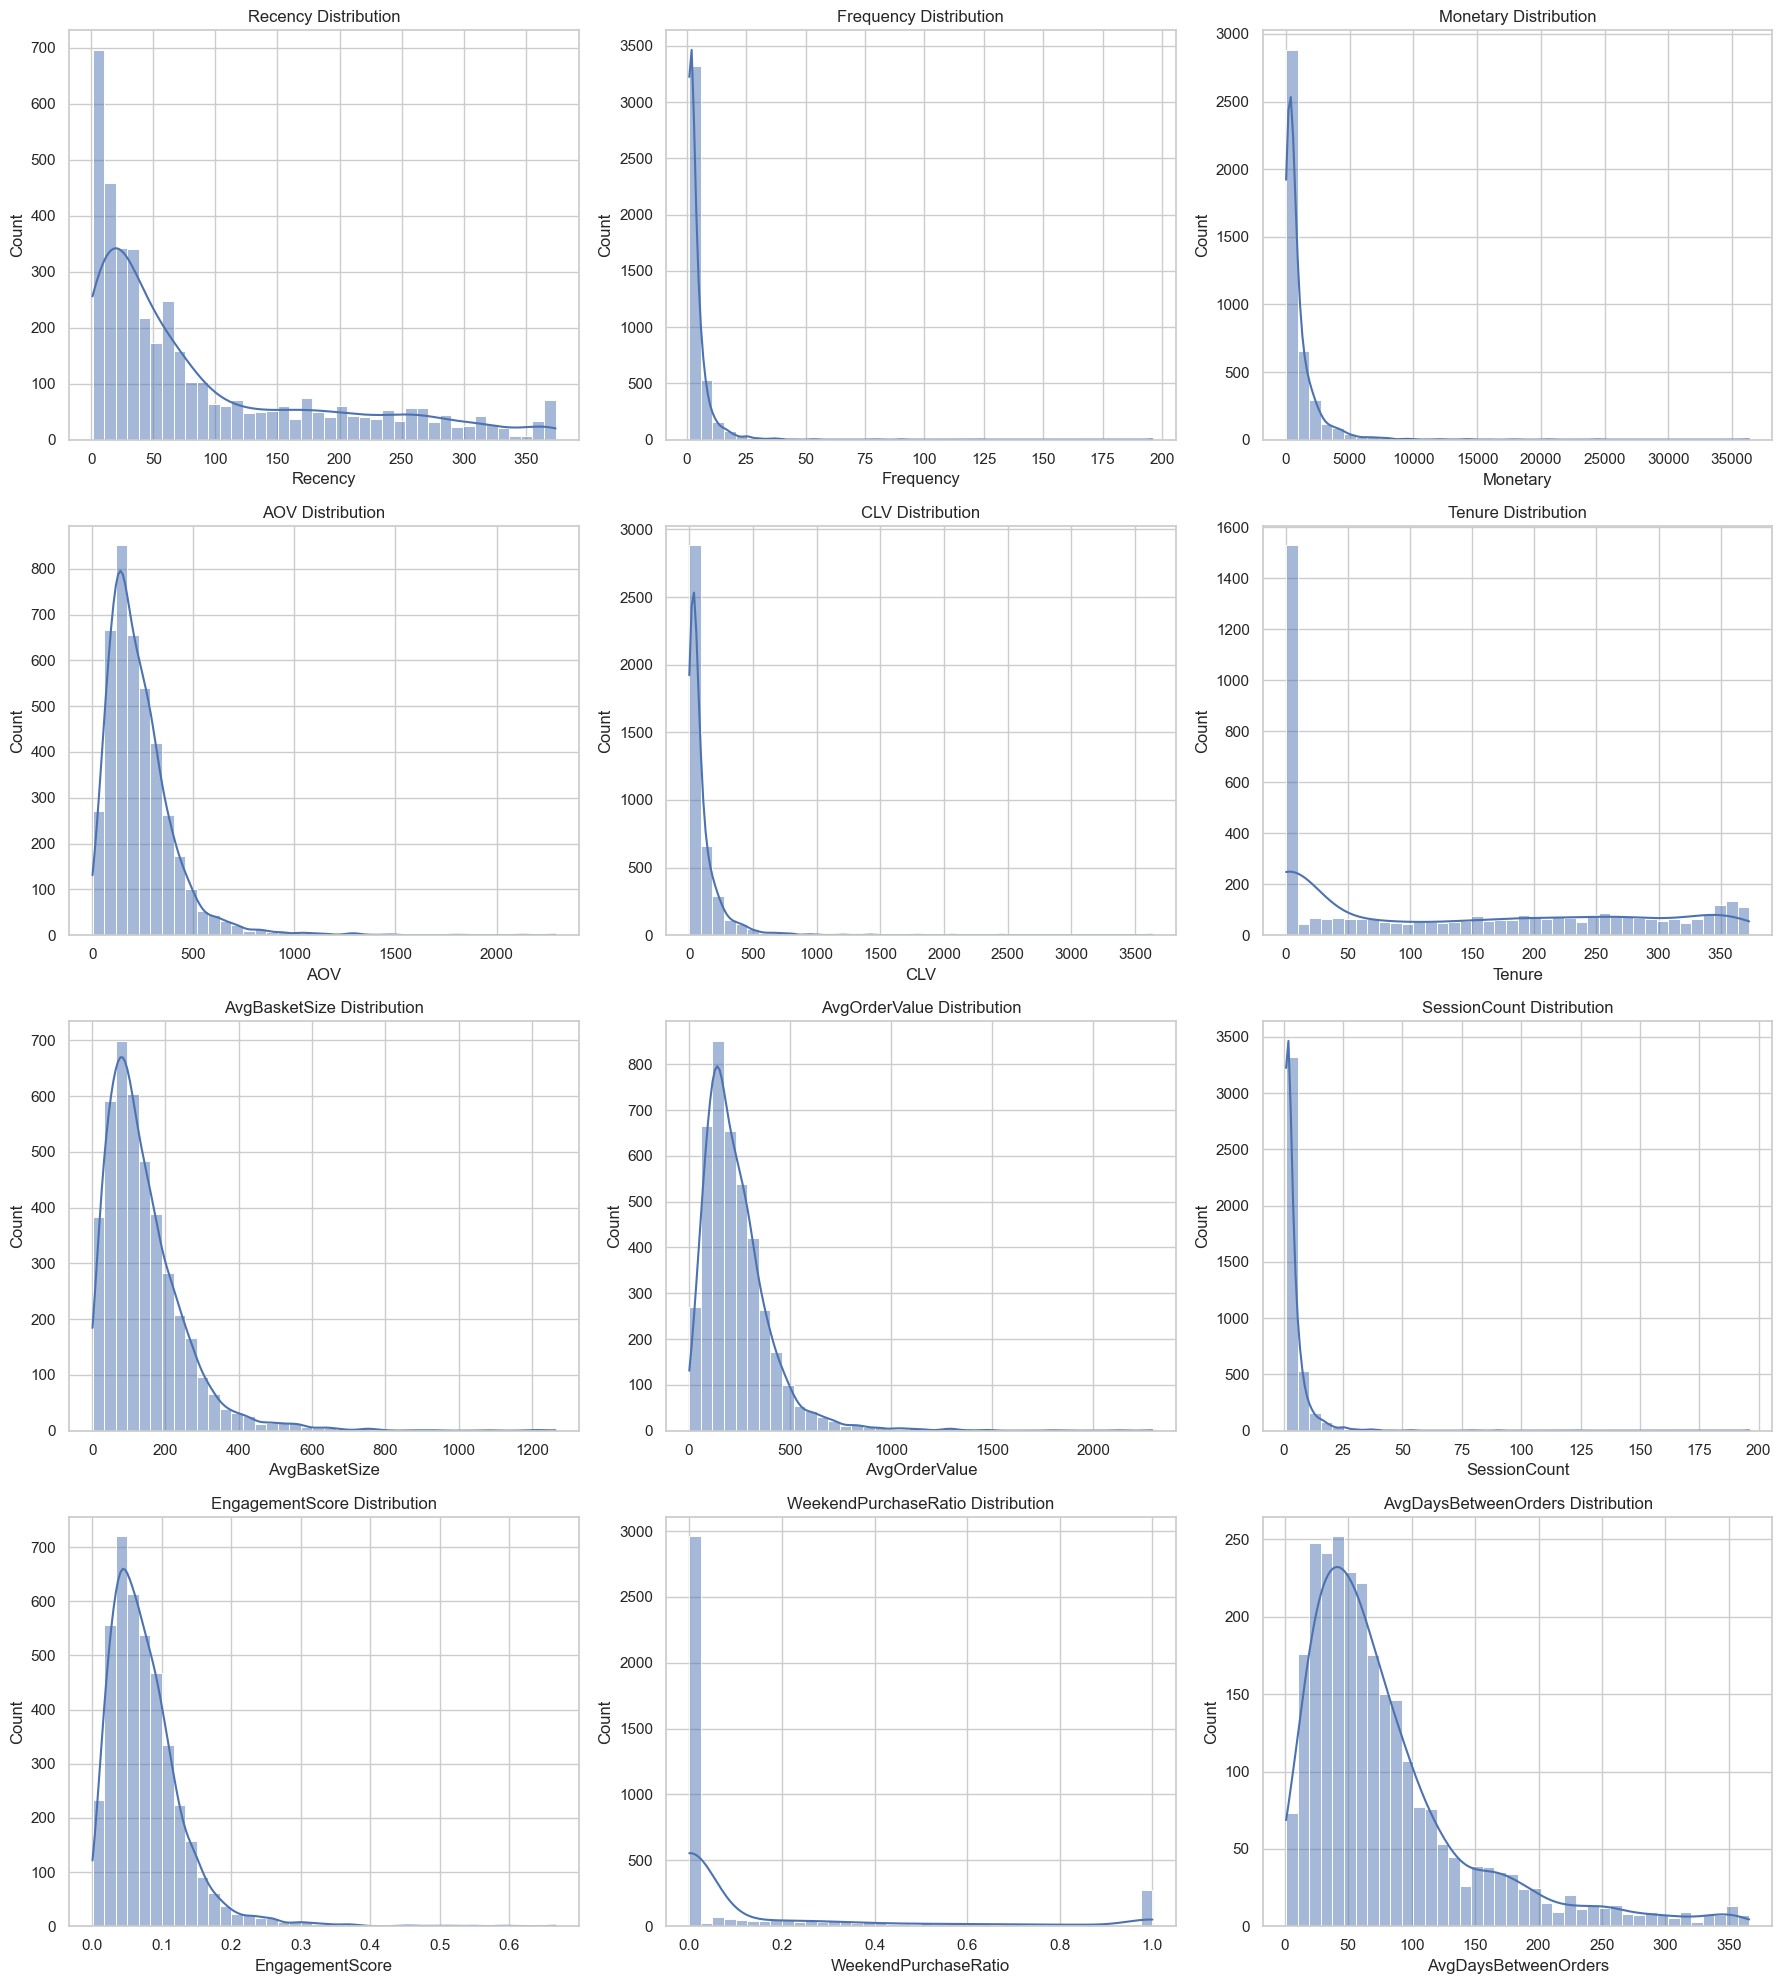

<Figure size 1000x600 with 0 Axes>

In [40]:
# Select main numeric features to visualize
feature_cols = ['Recency', 'Frequency', 'Monetary', 'AOV', 'CLV',
                'Tenure', 'AvgBasketSize', 'AvgOrderValue',
                'SessionCount', 'EngagementScore',
                'WeekendPurchaseRatio', 'AvgDaysBetweenOrders']

# Create grid of histograms
num_plots = len(feature_cols)
ncols = 3
nrows = (num_plots + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(18, 5 * nrows))

for i, col in enumerate(feature_cols):
    row, col_idx = divmod(i, ncols)
    sns.histplot(rfm[col], kde=True, bins=40, ax=axes[row][col_idx])
    axes[row][col_idx].set_title(f"{col} Distribution")

# Hide unused subplots
for j in range(i + 1, nrows * ncols):
    row, col_idx = divmod(j, ncols)
    axes[row][col_idx].axis('off')

plt.tight_layout()
save_figure(fig, "final_feature_distributions.png", "Phase3")
plt.show()
plt.clf()


### Visual Summary: Correlation Heatmap

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase3\feature_correlation_heatmap.png


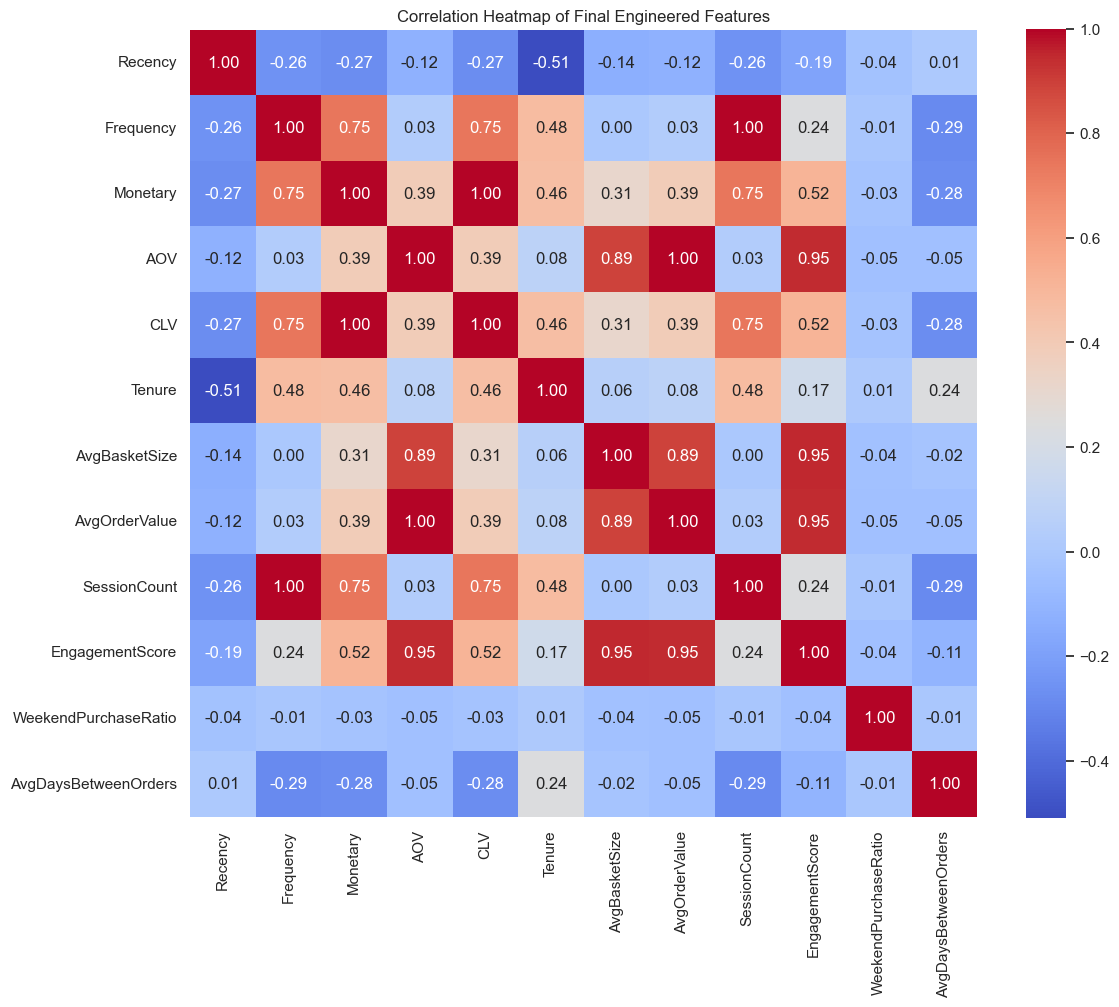

<Figure size 1000x600 with 0 Axes>

In [41]:
# Compute correlation matrix
corr_matrix = rfm[feature_cols].corr()

# Heatmap
fig = plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Heatmap of Final Engineered Features")
plt.tight_layout()
save_figure(fig, "feature_correlation_heatmap.png", "Phase3")
plt.show()
plt.clf()


### Save Final Features

In [42]:
# Save final engineered dataset
final_features_path = os.path.join(project_root, "Processed", "final_engineered_features.csv")
rfm.to_csv(final_features_path, index=False)
print(f"\nFinal feature dataset saved to: {final_features_path}")



Final feature dataset saved to: CustomerSegmentAI360\Processed\final_engineered_features.csv


# PHASE 4: Customer Segmentation

In [44]:
# Load Final engineered feature set
rfm = pd.read_csv(os.path.join(project_root, "Processed", "final_engineered_features.csv"))


## Step 4.1 – RFM Segmentation

In [45]:
# Create quartile-based scores
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1]).astype(int)  # Lower recency = better
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4]).astype(int)

# Create composite RFM segment code (e.g., "444" = best customers)
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Optionally, create a total RFM score
rfm['RFM_Score'] = rfm['R_Score'] + rfm['F_Score'] + rfm['M_Score']

# Preview
print("\nSample RFM Segments:")
print(rfm[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'RFM_Segment', 'RFM_Score']].head(10))

# Summary of segment distribution
print("\nTop 10 RFM Segments by Frequency:")
print(rfm['RFM_Segment'].value_counts().head(10))


Sample RFM Segments:
   CustomerID  Recency  Frequency  Monetary RFM_Segment  RFM_Score
0     12747.0        2         11   2640.41         444         12
1     12748.0        1        196  20519.88         444         12
2     12748.0        1        196  20519.88         444         12
3     12749.0        4          5   2737.73         434         11
4     12820.0        3          4    923.62         433         10
5     12821.0      214          1     75.72         111          3
6     12822.0       71          2    743.28         223          7
7     12824.0       60          1    316.42         212          5
8     12824.0       60          1    316.42         212          5
9     12826.0        3          7   1460.80         444         12

Top 10 RFM Segments by Frequency:
RFM_Segment
444    495
111    297
344    207
333    172
112    166
121    161
211    147
122    142
433    140
233    135
Name: count, dtype: int64


### Visualization: RFM Score Distribution

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase4\rfm_score_distribution.png


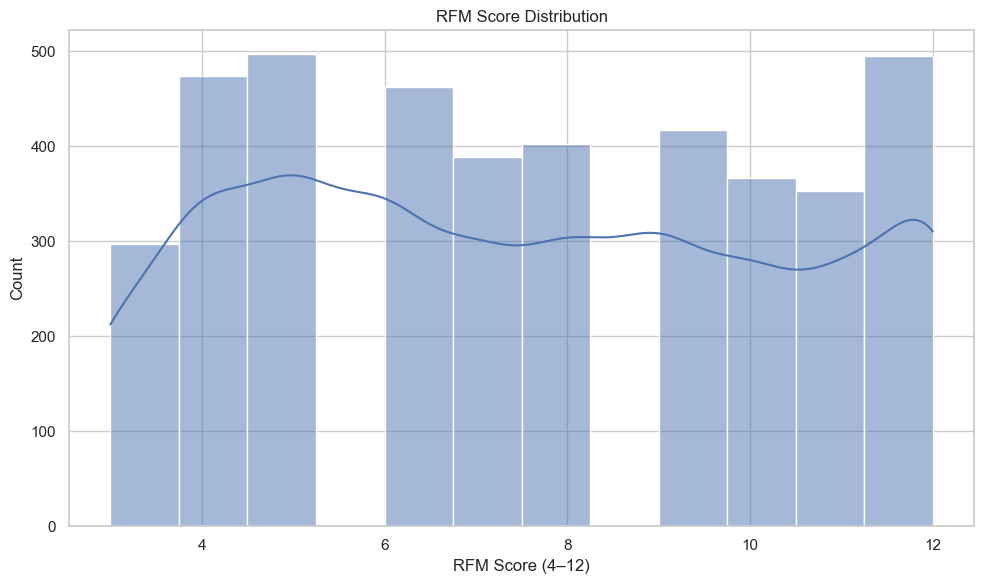

<Figure size 1000x600 with 0 Axes>

In [46]:
# Visualize overall RFM score distribution
fig = plt.figure(figsize=(10, 6))
sns.histplot(rfm['RFM_Score'], bins=12, kde=True)
plt.title("RFM Score Distribution")
plt.xlabel("RFM Score (4–12)")
plt.tight_layout()
save_figure(fig, "rfm_score_distribution.png", "Phase4")
plt.show()
plt.clf()


### Save RFM Segments

In [47]:
# Save RFM-segmented data
rfm_segmented_path = os.path.join(project_root, "Processed", "rfm_segmented.csv")
rfm.to_csv(rfm_segmented_path, index=False)
print(f"RFM segmentation saved to: {rfm_segmented_path}")


RFM segmentation saved to: CustomerSegmentAI360\Processed\rfm_segmented.csv


## Step 4.2 – CLV Tier Segmentation

In [48]:
# Create CLV Tier using quantile-based segmentation
rfm['CLV_Tier'] = pd.qcut(rfm['CLV'], q=[0, 0.25, 0.75, 1.0], labels=['Low', 'Medium', 'High'])

# Preview sample
print("\nSample CLV Tier Assignment:")
print(rfm[['CustomerID', 'CLV', 'CLV_Tier']].head(10))

# Distribution of tiers
print("\nCLV Tier Distribution:")
print(rfm['CLV_Tier'].value_counts())
print(rfm['CLV_Tier'].value_counts(normalize=True).map("{:.2%}".format))


Sample CLV Tier Assignment:
   CustomerID       CLV CLV_Tier
0     12747.0   264.041     High
1     12748.0  2051.988     High
2     12748.0  2051.988     High
3     12749.0   273.773     High
4     12820.0    92.362   Medium
5     12821.0     7.572      Low
6     12822.0    74.328   Medium
7     12824.0    31.642   Medium
8     12824.0    31.642   Medium
9     12826.0   146.080     High

CLV Tier Distribution:
CLV_Tier
Medium    2076
Low       1038
High      1038
Name: count, dtype: int64
CLV_Tier
Medium    50.00%
Low       25.00%
High      25.00%
Name: proportion, dtype: object


### Visualization: CLV Tier Distribution

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase4\clv_tier_distribution.png


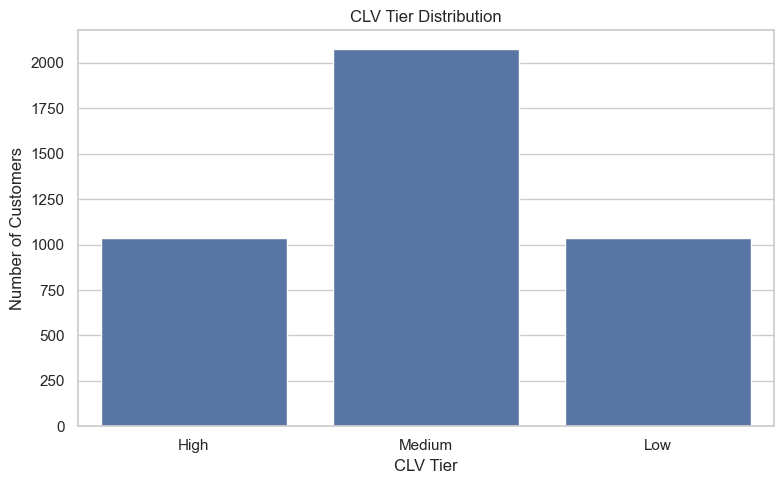

<Figure size 1000x600 with 0 Axes>

In [49]:
# Bar plot of CLV tier distribution
fig = plt.figure(figsize=(8, 5))
sns.countplot(x='CLV_Tier', data=rfm, order=['High', 'Medium', 'Low'])
plt.title("CLV Tier Distribution")
plt.xlabel("CLV Tier")
plt.ylabel("Number of Customers")
plt.tight_layout()
save_figure(fig, "clv_tier_distribution.png", "Phase4")
plt.show()
plt.clf()


### Save CLV Segment

In [50]:
# Save with CLV tier
clv_tier_path = os.path.join(project_root, "Processed", "rfm_with_clv_tier.csv")
rfm.to_csv(clv_tier_path, index=False)
print(f"CLV tiers saved to: {clv_tier_path}")


CLV tiers saved to: CustomerSegmentAI360\Processed\rfm_with_clv_tier.csv


## Step 4.3 – K-Means Clustering

In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Select features for clustering
cluster_features = ['Recency', 'Frequency', 'Monetary', 'AOV', 'CLV',
                    'Tenure', 'AvgBasketSize', 'SessionCount', 'EngagementScore']

X = rfm[cluster_features].copy()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


### Elbow Method: Find Optimal K

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase4\kmeans_elbow_curve.png


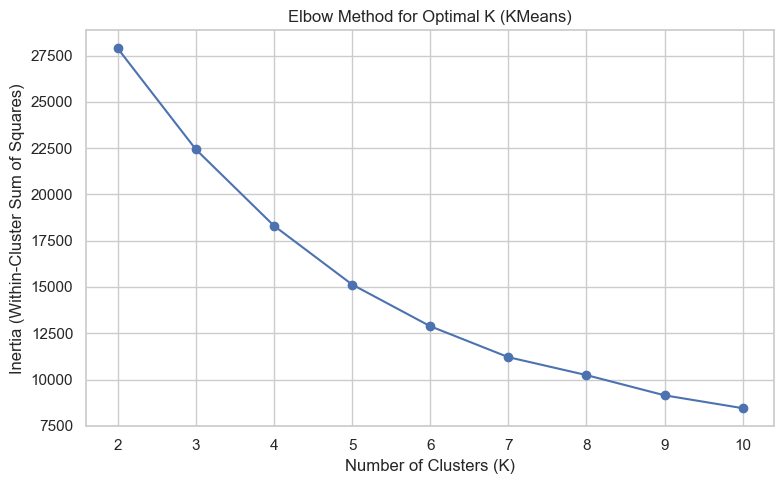

<Figure size 1000x600 with 0 Axes>

In [52]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow Method to Find Optimal K
inertia_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia_scores.append(kmeans.inertia_)

# Plot Elbow Curve
fig = plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia_scores, marker='o', linestyle='-')
plt.title("Elbow Method for Optimal K (KMeans)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.xticks(K_range)
plt.grid(True)
plt.tight_layout()

save_figure(fig, "kmeans_elbow_curve.png", "Phase4")
plt.show()
plt.clf()


### Silhouette Score

In [53]:
from sklearn.metrics import silhouette_score

print("\nSilhouette Scores for KMeans (using scaled clustering features):")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"K={k} → Silhouette Score: {score:.4f}")



Silhouette Scores for KMeans (using scaled clustering features):
K=2 → Silhouette Score: 0.3997
K=3 → Silhouette Score: 0.3534
K=4 → Silhouette Score: 0.3257
K=5 → Silhouette Score: 0.2982
K=6 → Silhouette Score: 0.2970
K=7 → Silhouette Score: 0.3052
K=8 → Silhouette Score: 0.3007
K=9 → Silhouette Score: 0.3012
K=10 → Silhouette Score: 0.3023


## Step 4.4 – PCA + K-Means Visualization (K = 4)

In [54]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Fit KMeans on scaled features
kmeans_final = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans_final.fit_predict(X_scaled)

# Add cluster labels to RFM
rfm['KMeans_Cluster'] = cluster_labels

# Apply PCA to reduce to 2 dimensions for visualization
pca = PCA(n_components=2, random_state=42)
pca_components = pca.fit_transform(X_scaled)

# Create PCA visualization DataFrame
pca_df = pd.DataFrame(data=pca_components, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = cluster_labels

In [55]:
# Preview: sample of customers with cluster assignment
print("\nSample Customers with Assigned Cluster:")
print(rfm[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'CLV', 'KMeans_Cluster']].head())



Sample Customers with Assigned Cluster:
   CustomerID  Recency  Frequency  Monetary       CLV  KMeans_Cluster
0     12747.0        2         11   2640.41   264.041               3
1     12748.0        1        196  20519.88  2051.988               2
2     12748.0        1        196  20519.88  2051.988               2
3     12749.0        4          5   2737.73   273.773               1
4     12820.0        3          4    923.62    92.362               3


In [56]:
# Preview: size of each cluster
print("\nCluster Sizes:")
print(rfm['KMeans_Cluster'].value_counts().sort_index())


Cluster Sizes:
KMeans_Cluster
0    2362
1     512
2       9
3    1269
Name: count, dtype: int64


In [57]:
# Preview: average behavior per cluster
cluster_summary = rfm.groupby('KMeans_Cluster')[cluster_features].mean().round(2)
print("\nCluster Behavior Summary (Mean Values):")
print(cluster_summary)


Cluster Behavior Summary (Mean Values):
                Recency  Frequency  Monetary     AOV      CLV  Tenure  \
KMeans_Cluster                                                          
0                127.68       1.84    294.31  164.84    29.43   53.39   
1                 76.56       2.83   1585.29  547.61   158.53  106.77   
2                  3.33      97.00  24480.83  505.53  2448.08  336.11   
3                 26.68       8.28   1930.46  236.92   193.05  286.49   

                AvgBasketSize  SessionCount  EngagementScore  
KMeans_Cluster                                                
0                       97.07          1.84             0.05  
1                      351.77          2.83             0.18  
2                      264.21         97.00             0.31  
3                      139.16          8.28             0.08  


### Visualization: 2D Scatter with Cluster Colors

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase4\pca_kmeans_clusters_k4.png


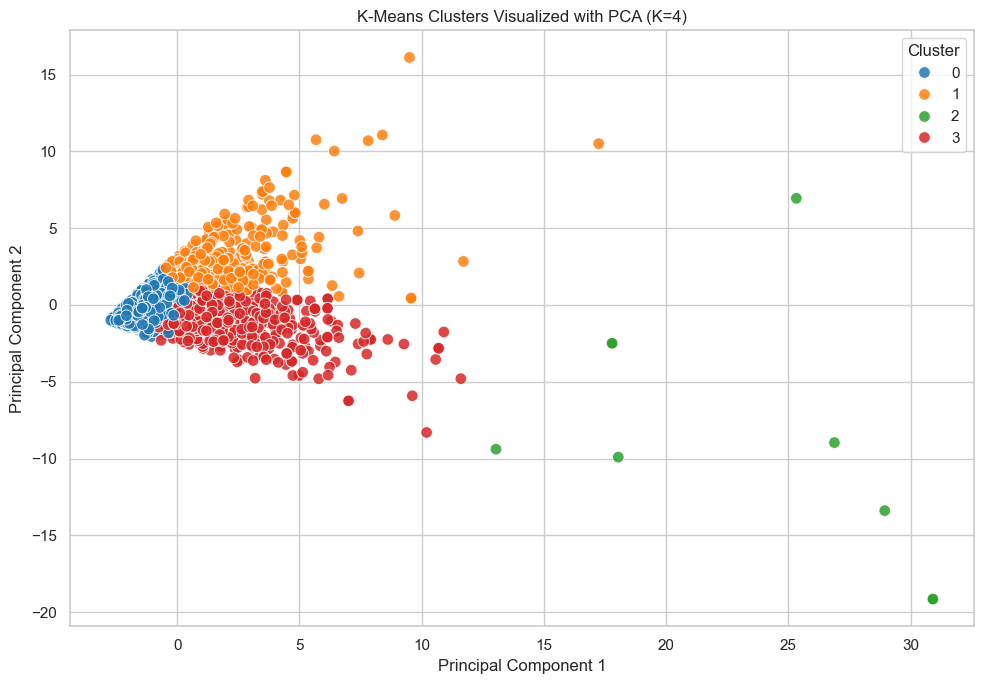

<Figure size 1000x600 with 0 Axes>

In [58]:
# Visualize clusters in PCA-reduced space
fig = plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=pca_df,
    x='PCA1', y='PCA2',
    hue='Cluster',
    palette='tab10',
    s=70,
    alpha=0.85
)
plt.title("K-Means Clusters Visualized with PCA (K=4)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster')
plt.tight_layout()
save_figure(fig, "pca_kmeans_clusters_k4.png", "Phase4")
plt.show()
plt.clf()


### Save K-Means Cluster

In [59]:
# Save cluster summary for dashboard/report
cluster_summary_path = os.path.join(project_root, "Processed", "kmeans_cluster_summary.csv")
cluster_summary.to_csv(cluster_summary_path)
print(f"\nCluster summary saved to: {cluster_summary_path}")


Cluster summary saved to: CustomerSegmentAI360\Processed\kmeans_cluster_summary.csv


## Step 4.5 – DBSCAN Clustering

In [60]:
from sklearn.cluster import DBSCAN

# Fit DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Add to RFM dataset
rfm['DBSCAN_Cluster'] = dbscan_labels

# Summary of cluster labels
print("\nDBSCAN Cluster Label Counts:")
print(rfm['DBSCAN_Cluster'].value_counts().sort_index())



DBSCAN Cluster Label Counts:
DBSCAN_Cluster
-1      43
 0    4109
Name: count, dtype: int64


### Visualization for DBSCAN

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase4\pca_dbscan_clusters.png


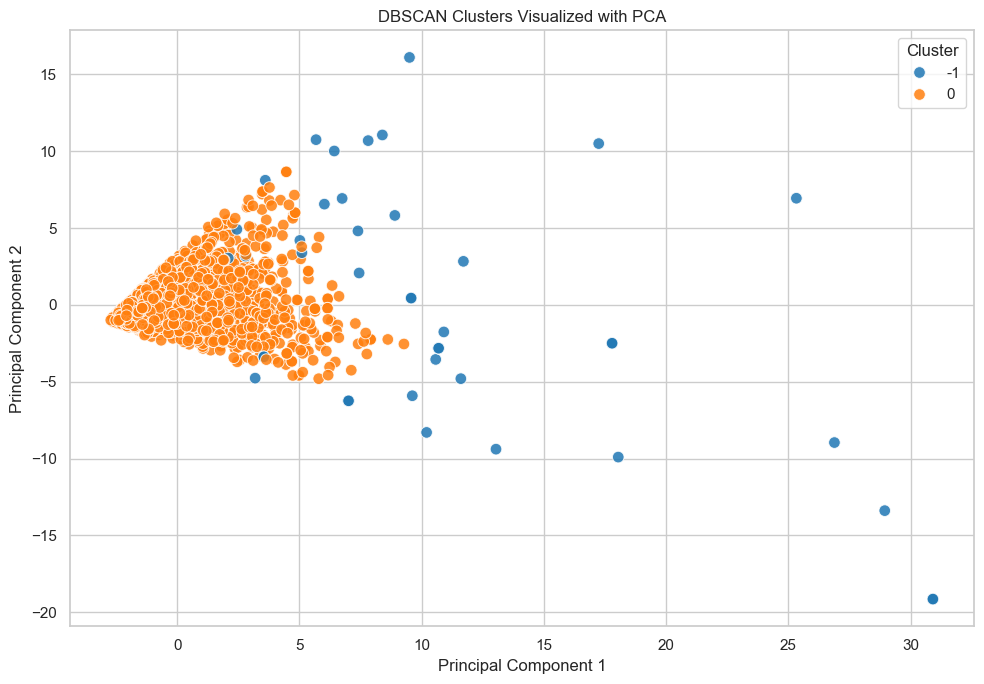

<Figure size 1000x600 with 0 Axes>

In [61]:
# Add DBSCAN labels to PCA DataFrame
pca_df['DBSCAN_Cluster'] = dbscan_labels

# Visualize DBSCAN results
fig = plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=pca_df,
    x='PCA1', y='PCA2',
    hue='DBSCAN_Cluster',
    palette='tab10',
    s=70,
    alpha=0.85
)
plt.title("DBSCAN Clusters Visualized with PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster')
plt.tight_layout()
save_figure(fig, "pca_dbscan_clusters.png", "Phase4")
plt.show()
plt.clf()


In [62]:
noise_ratio = (rfm['DBSCAN_Cluster'] == -1).mean()
print(f"\nNoise ratio: {noise_ratio:.2%}")



Noise ratio: 1.04%


## Step 4.6 – Hierarchical Clustering

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase4\hierarchical_dendrogram.png


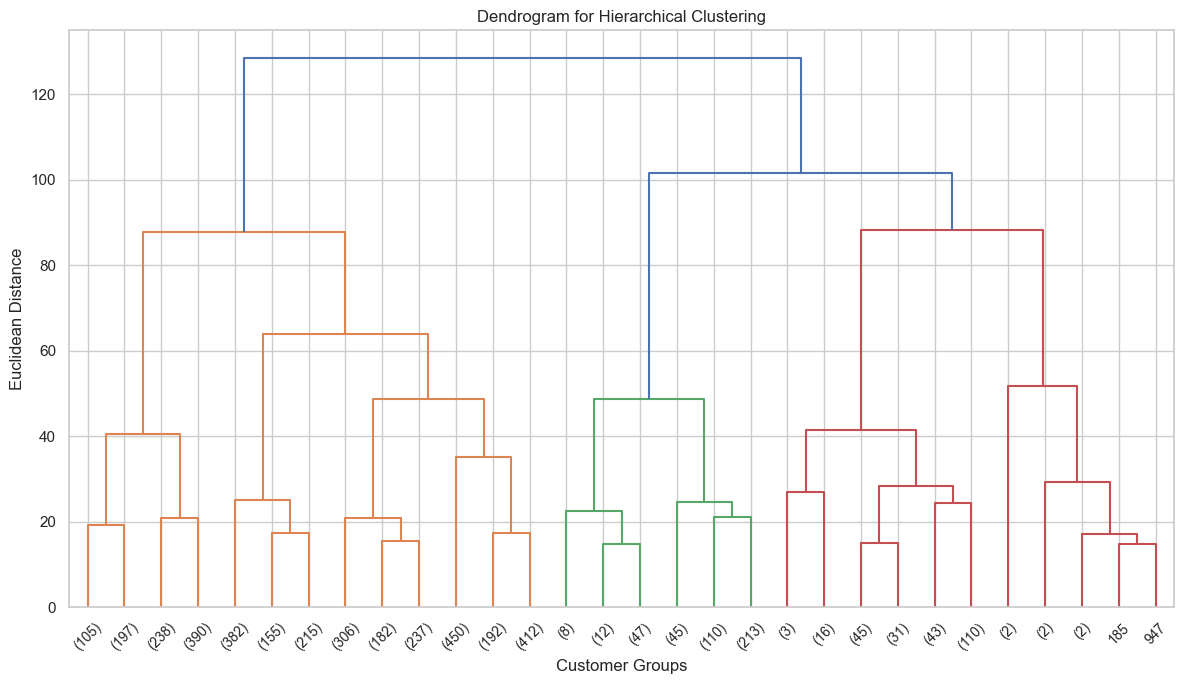

<Figure size 1000x600 with 0 Axes>

In [63]:
import scipy.cluster.hierarchy as sch

# Create linkage matrix
linkage_matrix = sch.linkage(X_scaled, method='ward')

# Plot dendrogram
fig = plt.figure(figsize=(12, 7))
dendrogram = sch.dendrogram(linkage_matrix, truncate_mode='lastp', p=30)
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Customer Groups")
plt.ylabel("Euclidean Distance")
plt.tight_layout()
save_figure(fig, "hierarchical_dendrogram.png", "Phase4")
plt.show()
plt.clf()


In [64]:
from sklearn.cluster import AgglomerativeClustering

# Corrected Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
agglo_labels = agglo.fit_predict(X_scaled)

# Assign cluster labels
rfm['Hierarchical_Cluster'] = agglo_labels


### Visualization for Hierarchical Segmentation

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase4\pca_hierarchical_clusters_k4.png


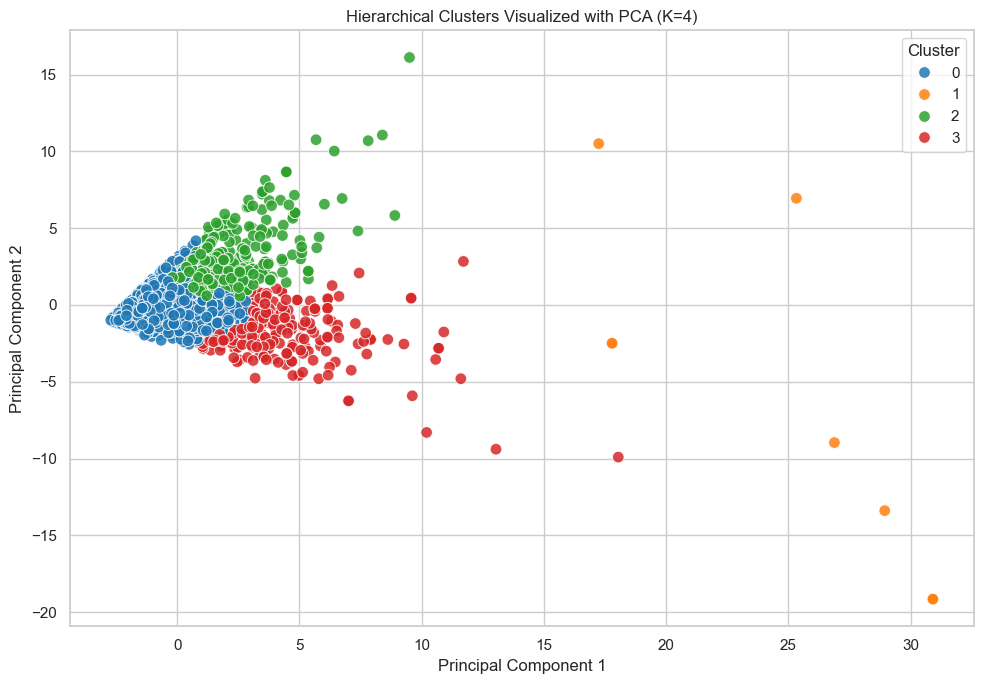

<Figure size 1000x600 with 0 Axes>

In [65]:
# Add labels to PCA DataFrame
pca_df['Hierarchical_Cluster'] = agglo_labels

# Plot clusters in PCA space
fig = plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=pca_df,
    x='PCA1', y='PCA2',
    hue='Hierarchical_Cluster',
    palette='tab10',
    s=70,
    alpha=0.85
)
plt.title("Hierarchical Clusters Visualized with PCA (K=4)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster')
plt.tight_layout()
save_figure(fig, "pca_hierarchical_clusters_k4.png", "Phase4")
plt.show()
plt.clf()


In [66]:
# Cluster behavior summary
hierarchical_summary = rfm.groupby('Hierarchical_Cluster')[cluster_features].mean().round(2)
print("\nHierarchical Cluster Behavior Summary:")
print(hierarchical_summary)

# Save to CSV
hierarchical_summary_path = os.path.join(project_root, "Processed", "hierarchical_cluster_summary.csv")
hierarchical_summary.to_csv(hierarchical_summary_path)
print(f"\nHierarchical cluster summary saved to: {hierarchical_summary_path}")



Hierarchical Cluster Behavior Summary:
                      Recency  Frequency  Monetary     AOV      CLV  Tenure  \
Hierarchical_Cluster                                                          
0                       99.47       2.98    591.44  189.84    59.14  117.16   
1                        5.00      87.75  26541.58  757.06  2654.16  329.88   
2                       61.45       3.03   1638.32  559.41   163.83  129.53   
3                       14.64      19.51   4858.53  276.26   485.85  334.23   

                      AvgBasketSize  SessionCount  EngagementScore  
Hierarchical_Cluster                                                
0                            113.08          2.98             0.06  
1                            428.74         87.75             0.37  
2                            357.75          3.03             0.18  
3                            152.92         19.51             0.11  

Hierarchical cluster summary saved to: CustomerSegmentAI360\Processed\

## Step 4.7 – GMM Clustering

In [67]:
from sklearn.mixture import GaussianMixture

# Fit GMM with 4 components
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)

# Assign cluster labels to RFM dataset
rfm['GMM_Cluster'] = gmm_labels

# Get cluster membership probabilities (optional for soft labeling)
gmm_probs = gmm.predict_proba(X_scaled)

# Count of customers in each GMM cluster
print("\nGMM Cluster Sizes:")
print(rfm['GMM_Cluster'].value_counts().sort_index())

# Cluster behavior summary
gmm_summary = rfm.groupby('GMM_Cluster')[cluster_features].mean().round(2)
print("\nGMM Cluster Behavior Summary:")
print(gmm_summary)


GMM Cluster Sizes:
GMM_Cluster
0    1437
1    1361
2     332
3    1022
Name: count, dtype: int64

GMM Cluster Behavior Summary:
             Recency  Frequency  Monetary     AOV     CLV  Tenure  \
GMM_Cluster                                                         
0             152.34       1.00    218.55  218.55   21.86    0.00   
1              85.61       2.57    618.49  231.92   61.85  131.41   
2              14.73      17.44   5018.28  401.79  501.83  316.08   
3              33.60       6.33   1325.85  207.27  132.58  257.89   

             AvgBasketSize  SessionCount  EngagementScore  
GMM_Cluster                                                
0                   134.56          1.00             0.07  
1                   141.19          2.57             0.07  
2                   236.94         17.44             0.15  
3                   121.49          6.33             0.07  


### Visualization for GMM

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase4\pca_gmm_clusters_k4.png


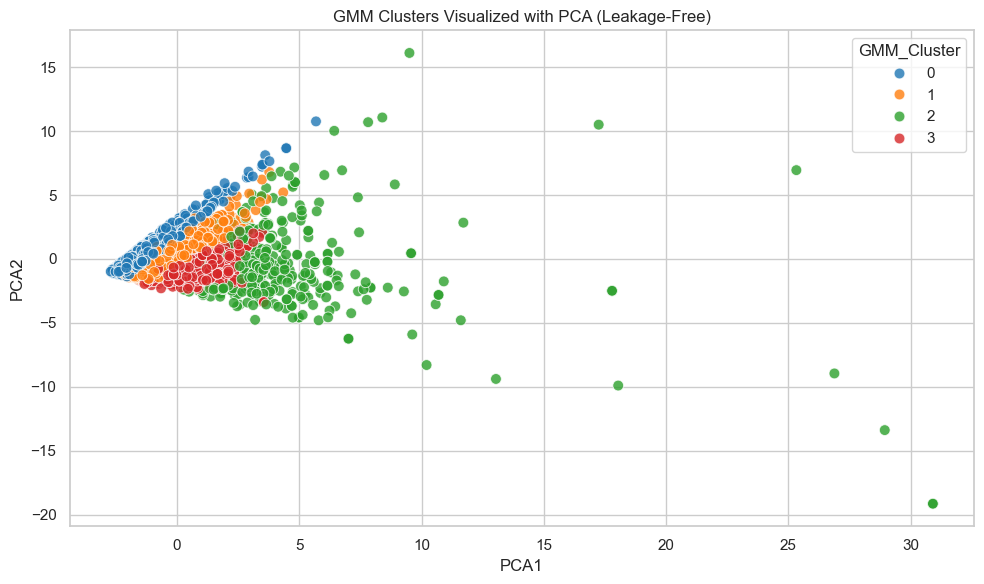

<Figure size 1000x600 with 0 Axes>

In [75]:
pca_df['GMM_Cluster'] = gmm_labels

fig = plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='GMM_Cluster',
    palette='tab10', data=pca_df, s=60, alpha=0.8
)
plt.title("GMM Clusters Visualized with PCA (Leakage-Free)")
plt.tight_layout()
save_figure(fig, "pca_gmm_clusters_k4.png", "Phase4")
plt.show()
plt.clf()


### Save GMM Cluster

In [76]:
# Save to CSV
gmm_summary_path = os.path.join(project_root, "Processed", "gmm_cluster_summary.csv")
gmm_summary.to_csv(gmm_summary_path)
print(f"\nGMM cluster summary saved to: {gmm_summary_path}")



GMM cluster summary saved to: CustomerSegmentAI360\Processed\gmm_cluster_summary.csv


## Step 4.8 – Cluster Profile Summary

In [77]:
cluster_profile = rfm.groupby('KMeans_Cluster')[cluster_features].mean().round(2)
cluster_profile['CustomerCount'] = rfm['KMeans_Cluster'].value_counts().sort_index()

# Reorder columns (CustomerCount first)
cols = ['CustomerCount'] + cluster_features
cluster_profile = cluster_profile[cols]

# Display summary
print("\nKMeans Cluster Profile Summary:")
print(cluster_profile)



KMeans Cluster Profile Summary:
                CustomerCount  Recency  Frequency  Monetary     AOV      CLV  \
KMeans_Cluster                                                                 
0                        2362   127.68       1.84    294.31  164.84    29.43   
1                         512    76.56       2.83   1585.29  547.61   158.53   
2                           9     3.33      97.00  24480.83  505.53  2448.08   
3                        1269    26.68       8.28   1930.46  236.92   193.05   

                Tenure  AvgBasketSize  SessionCount  EngagementScore  
KMeans_Cluster                                                        
0                53.39          97.07          1.84             0.05  
1               106.77         351.77          2.83             0.18  
2               336.11         264.21         97.00             0.31  
3               286.49         139.16          8.28             0.08  


### Auto-Label KMeans Clusters Based on Behavioral Rules

In [83]:
# Calculate mean values for each KMeans cluster

cluster_profile = rfm.groupby('KMeans_Cluster')[cluster_features].mean()

cluster_labels_map = {}

# Define dynamic thresholds using quantiles
recency_q = cluster_profile['Recency'].quantile([0.25, 0.75])
frequency_q = cluster_profile['Frequency'].quantile([0.25, 0.75])
clv_q = cluster_profile['CLV'].quantile([0.25, 0.75])
monetary_q = cluster_profile['Monetary'].quantile([0.25, 0.75])

for cluster_id, row in cluster_profile.iterrows():
    recency = row['Recency']
    frequency = row['Frequency']
    clv = row['CLV']
    monetary = row['Monetary']

    if recency <= recency_q[0.25] and frequency >= frequency_q[0.75] and clv >= clv_q[0.75]:
        label = "VIP"
    elif recency >= recency_q[0.75] and frequency <= frequency_q[0.25] and clv <= clv_q[0.25]:
        label = "At Risk"
    elif monetary >= monetary_q[0.75]:
        label = "Big Spender"
    elif frequency <= frequency_q[0.25] and clv >= clv_q[0.5]:
        label = "Casual Buyer"
    elif frequency >= frequency_q[0.75] and monetary <= monetary_q[0.25]:
        label = "Bargain Hunter"
    elif recency <= recency_q[0.25] and frequency <= frequency_q[0.25] and clv <= clv_q[0.25]:
        label = "New Customer"
    else:
        label = "General"

    cluster_labels_map[cluster_id] = label

# Map labels to dataset
rfm['KMeans_Label'] = rfm['KMeans_Cluster'].map(cluster_labels_map)

# Show results
print("\nUpdated KMeans Cluster Labels Mapping:")
print(cluster_labels_map)

print("\nLabel Distribution:")
print(rfm['KMeans_Label'].value_counts())




Updated KMeans Cluster Labels Mapping:
{0: 'At Risk', 1: 'General', 2: 'VIP', 3: 'General'}

Label Distribution:
KMeans_Label
At Risk    2362
General    1781
VIP           9
Name: count, dtype: int64


Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase4\pca_kmeans_labeled_segments.png


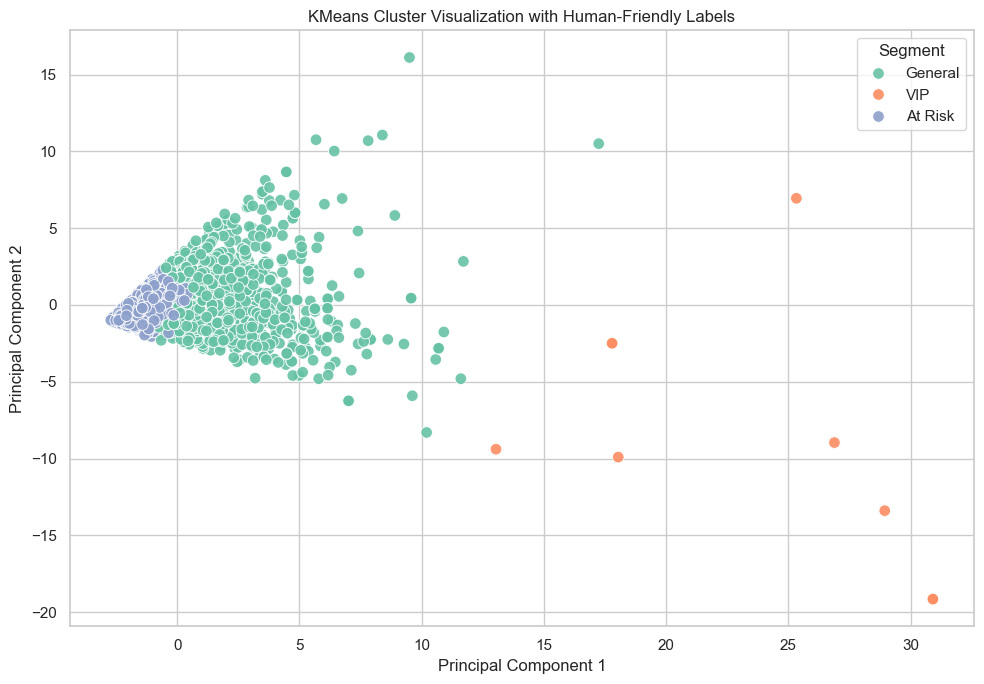

<Figure size 1000x600 with 0 Axes>

In [84]:
# PCA Visualization with Human-Friendly KMeans Segment Labels

# Add KMeans_Label to PCA dataframe for visualization
pca_df['KMeans_Label'] = rfm['KMeans_Label']

# Plot labeled PCA scatter plot
fig = plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=pca_df,
    x='PCA1', y='PCA2',
    hue='KMeans_Label',
    palette='Set2',
    s=70,
    alpha=0.9
)
plt.title("KMeans Cluster Visualization with Human-Friendly Labels")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Segment')
plt.tight_layout()
save_figure(fig, "pca_kmeans_labeled_segments.png", "Phase4")
plt.show()
plt.clf()


Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase4\kmeans_segment_distribution.png


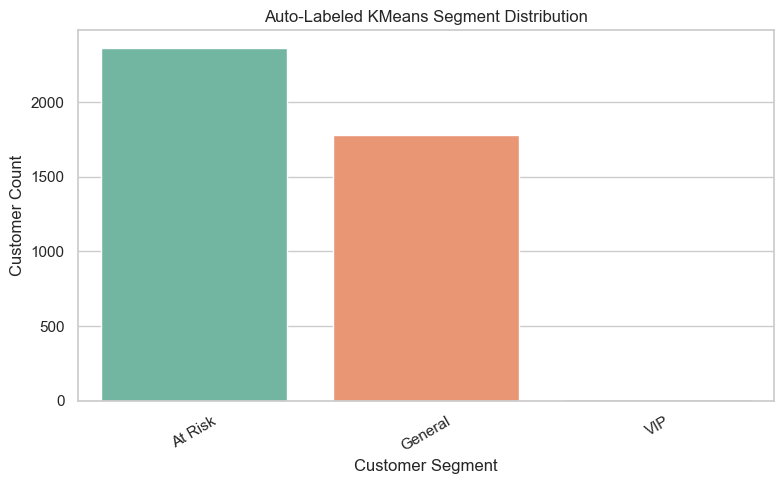

<Figure size 1000x600 with 0 Axes>

In [85]:
# Bar Chart – Distribution of Auto-Labeled KMeans Segments

fig = plt.figure(figsize=(8, 5))
sns.countplot(
    x='KMeans_Label',
    data=rfm,
    order=rfm['KMeans_Label'].value_counts().index,
    palette='Set2'
)
plt.title("Auto-Labeled KMeans Segment Distribution")
plt.xticks(rotation=30)
plt.xlabel("Customer Segment")
plt.ylabel("Customer Count")
plt.tight_layout()
save_figure(fig, "kmeans_segment_distribution.png", "Phase4")
plt.show()
plt.clf()


## Step 4.9 – Heatmap of Cluster Behavior

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase4\cluster_behavior_heatmap.png


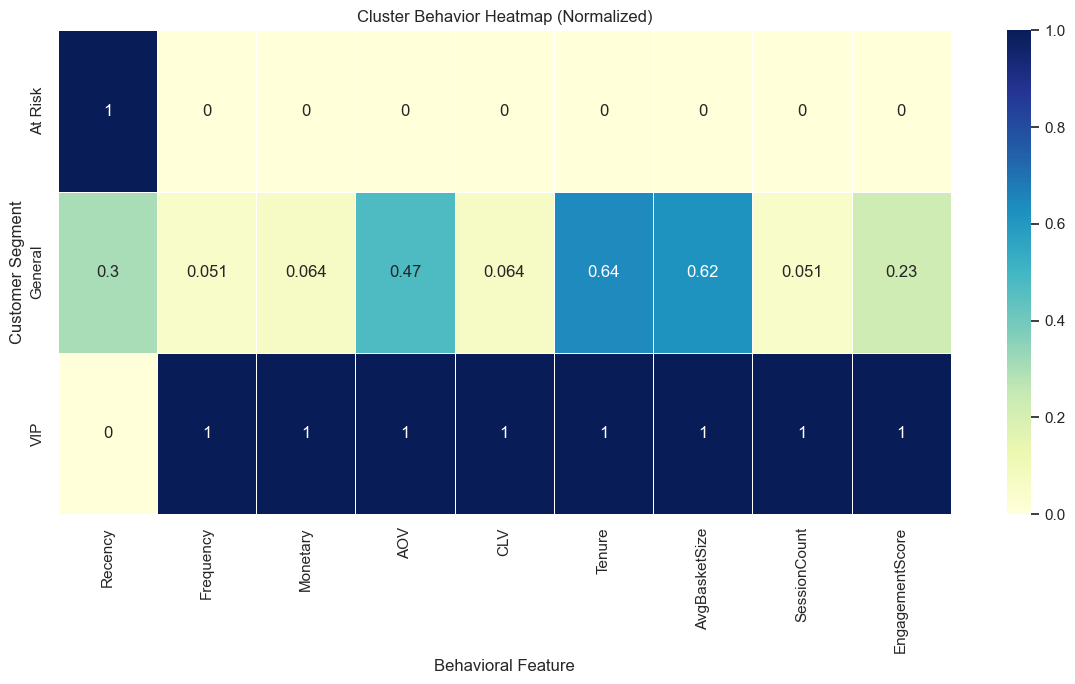

<Figure size 1000x600 with 0 Axes>

In [88]:
# Create heatmap data from KMeans-labeled cluster profiles
heatmap_df = rfm.groupby('KMeans_Label')[cluster_features].mean()

# Normalize using Min-Max scaling for better visual comparison
heatmap_normalized = (heatmap_df - heatmap_df.min()) / (heatmap_df.max() - heatmap_df.min())

# Plot heatmap
fig = plt.figure(figsize=(12, 7))
sns.heatmap(
    heatmap_normalized,
    annot=True,
    cmap="YlGnBu",
    cbar=True,
    linewidths=0.5
)
plt.title("Cluster Behavior Heatmap (Normalized)")
plt.xlabel("Behavioral Feature")
plt.ylabel("Customer Segment")
plt.tight_layout()
save_figure(fig, "cluster_behavior_heatmap.png", "Phase4") 
plt.show()
plt.clf()


## Step 4.10 – Unified Master View

In [90]:
# Define key fields to include
master_view_cols = [
    'CustomerID', 'Recency', 'Frequency', 'Monetary', 'AOV', 'CLV',
    'Churned', 'CLV_Tier',
    'KMeans_Cluster', 'KMeans_Label',
    'Hierarchical_Cluster', 'GMM_Cluster'
]

# Add advanced engineered features if available
optional_fields = ['Tenure', 'AvgBasketSize', 'AvgOrderValue', 'SessionCount', 'EngagementScore']
for field in optional_fields:
    if field in rfm.columns:
        master_view_cols.append(field)

# Create unified master view DataFrame
unified_df = rfm[master_view_cols].copy()

# Preview sample records
print("\nUnified Master View (Sample):")
print(unified_df.head())

# Report shape of the final dataset
print(f"\nShape of Unified View: {unified_df.shape}")



Unified Master View (Sample):
   CustomerID  Recency  Frequency  Monetary         AOV       CLV  Churned  \
0     12747.0        2         11   2640.41  240.037273   264.041        0   
1     12748.0        1        196  20519.88  104.693265  2051.988        0   
2     12748.0        1        196  20519.88  104.693265  2051.988        0   
3     12749.0        4          5   2737.73  547.546000   273.773        0   
4     12820.0        3          4    923.62  230.905000    92.362        0   

  CLV_Tier  KMeans_Cluster KMeans_Label  Hierarchical_Cluster  GMM_Cluster  \
0     High               3      General                     0            3   
1     High               2          VIP                     1            2   
2     High               2          VIP                     1            2   
3     High               1      General                     2            2   
4   Medium               3      General                     0            3   

   Tenure  AvgBasketSize  AvgOr

### Save Masterview

In [91]:
# Save to CSV
unified_view_path = os.path.join(project_root, "Processed", "unified_customer_master.csv")
unified_df.to_csv(unified_view_path, index=False)
print(f"\nUnified master view saved to: {unified_view_path}")



Unified master view saved to: CustomerSegmentAI360\Processed\unified_customer_master.csv


## Step 4.11 – Clustering Comparison

In [92]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Initialize list to hold comparison results
comparison = []

# Function to evaluate a clustering model
def evaluate_clustering(X_scaled, labels, model_name):
    num_clusters = len(set(labels))
    
    # Skip if all labels are the same or equal to number of samples
    if num_clusters > 1 and num_clusters < len(X_scaled):
        silhouette = silhouette_score(X_scaled, labels)
        db_index = davies_bouldin_score(X_scaled, labels)
        ch_score = calinski_harabasz_score(X_scaled, labels)
        
        comparison.append({
            'Model': model_name,
            'Silhouette Score': round(silhouette, 4),
            'Davies-Bouldin Index': round(db_index, 4),
            'Calinski-Harabasz Score': round(ch_score, 2),
            'Clusters': num_clusters
        })
    else:
        comparison.append({
            'Model': model_name,
            'Silhouette Score': None,
            'Davies-Bouldin Index': None,
            'Calinski-Harabasz Score': None,
            'Clusters': num_clusters
        })

# Evaluate available clustering models
evaluate_clustering(X_scaled, rfm['KMeans_Cluster'], 'KMeans')
evaluate_clustering(X_scaled, rfm['GMM_Cluster'], 'GMM')
evaluate_clustering(X_scaled, rfm['Hierarchical_Cluster'], 'Hierarchical')
if 'DBSCAN_Cluster' in rfm.columns:
    evaluate_clustering(X_scaled, rfm['DBSCAN_Cluster'], 'DBSCAN')

# Convert to DataFrame
comparison_df = pd.DataFrame(comparison)

# Show the comparison results
print("\nClustering Model Comparison:")
print(comparison_df)



Clustering Model Comparison:
          Model  Silhouette Score  Davies-Bouldin Index  \
0        KMeans            0.3257                1.0190   
1           GMM            0.0886                2.1847   
2  Hierarchical            0.4034                0.9406   
3        DBSCAN            0.7741                1.1784   

   Calinski-Harabasz Score  Clusters  
0                  1439.37         4  
1                   695.14         4  
2                  1193.39         4  
3                   676.53         2  


### Sort models by Silhouette Score

In [93]:
comparison_df_sorted = comparison_df.sort_values(by='Silhouette Score', ascending=False)
print("\nSorted by Silhouette Score:")
print(comparison_df_sorted)



Sorted by Silhouette Score:
          Model  Silhouette Score  Davies-Bouldin Index  \
3        DBSCAN            0.7741                1.1784   
2  Hierarchical            0.4034                0.9406   
0        KMeans            0.3257                1.0190   
1           GMM            0.0886                2.1847   

   Calinski-Harabasz Score  Clusters  
3                   676.53         2  
2                  1193.39         4  
0                  1439.37         4  
1                   695.14         4  


### Visualize the Comparison

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase4\clustering_model_comparison.png


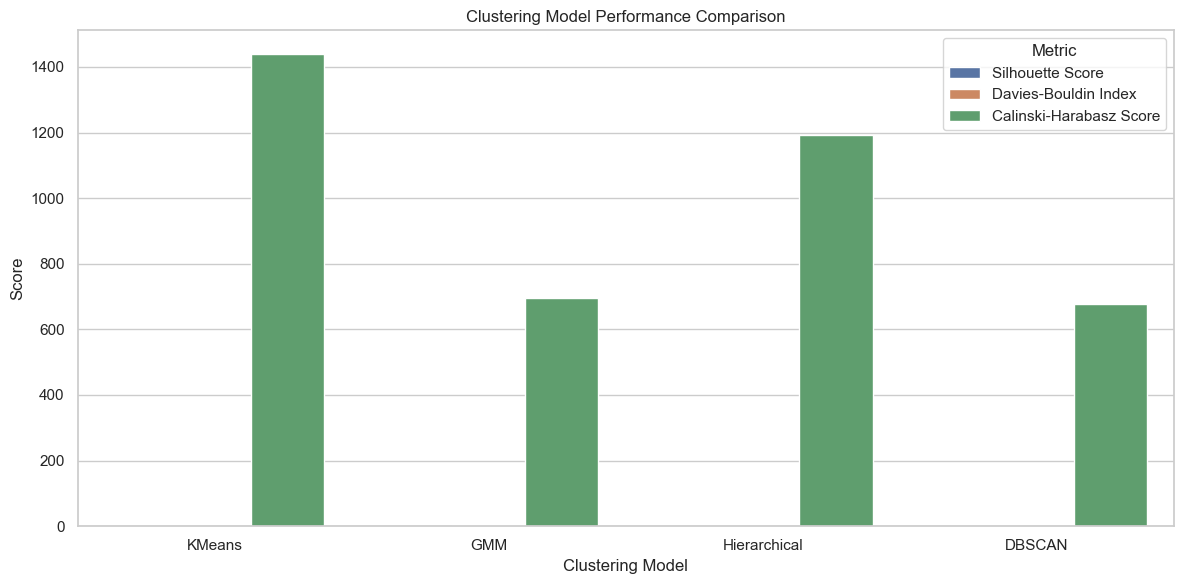

<Figure size 1000x600 with 0 Axes>

In [94]:
# Melt comparison DataFrame for easier plotting
comparison_melted = comparison_df.melt(
    id_vars='Model',
    value_vars=['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Score'],
    var_name='Metric',
    value_name='Score'
)

# Create bar plot to compare models across metrics
fig = plt.figure(figsize=(12, 6))
sns.barplot(
    data=comparison_melted,
    x='Model', y='Score',
    hue='Metric'
)
plt.title("Clustering Model Performance Comparison")
plt.ylabel("Score")
plt.xlabel("Clustering Model")
plt.tight_layout()
save_figure(fig, "clustering_model_comparison.png", "Phase4") 
plt.show()
plt.clf()

## Step 4.12 – Export Key Segments and Insights

In [95]:
# Step 4.12: Export Final Customer Segments to CSV

# Create export folder for segments
segment_folder = os.path.join(project_root, "Processed", "Segments")
os.makedirs(segment_folder, exist_ok=True)

# Define filters for key segments
segments = {
    'vip_customers.csv': rfm[rfm['KMeans_Label'] == 'VIP'],
    'at_risk_customers.csv': rfm[(rfm['KMeans_Label'] == 'At Risk') | (rfm['Churned'] == 1)],
    'churned_customers.csv': rfm[rfm['Churned'] == 1],
    'big_spenders.csv': rfm[rfm['KMeans_Label'] == 'Big Spender'],
    'bargain_hunters.csv': rfm[rfm['KMeans_Label'] == 'Bargain Hunter'],
    'all_segmented_customers.csv': rfm
}

# Export each segment as CSV
for filename, df in segments.items():
    export_path = os.path.join(segment_folder, filename)
    df.to_csv(export_path, index=False)
    print(f"Exported: {filename} ({df.shape[0]} rows) → {export_path}")


Exported: vip_customers.csv (9 rows) → CustomerSegmentAI360\Processed\Segments\vip_customers.csv
Exported: at_risk_customers.csv (2536 rows) → CustomerSegmentAI360\Processed\Segments\at_risk_customers.csv
Exported: churned_customers.csv (1352 rows) → CustomerSegmentAI360\Processed\Segments\churned_customers.csv
Exported: big_spenders.csv (0 rows) → CustomerSegmentAI360\Processed\Segments\big_spenders.csv
Exported: bargain_hunters.csv (0 rows) → CustomerSegmentAI360\Processed\Segments\bargain_hunters.csv
Exported: all_segmented_customers.csv (4152 rows) → CustomerSegmentAI360\Processed\Segments\all_segmented_customers.csv


# PHASE 5: Predictive Modeling

# Model 1: Churn Prediction

## Step 5.1: Train-Test Split for Churn Prediction

In [98]:
from sklearn.model_selection import train_test_split

# Define safe, non-leaky features
safe_features = [
    'Recency', 'Frequency', 'Monetary', 'AOV',
    'AvgBasketSize', 'AvgOrderValue',
    'WeekendPurchaseRatio', 'AvgDaysBetweenOrders'
]

# Filter rows with valid features and target
churn_df = rfm.dropna(subset=safe_features + ['Churned'])

# Define features (X) and target (y)
X = churn_df[safe_features]
y = churn_df['Churned']

# Perform stratified train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Summary output
print(f"Features used: {safe_features}")
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print("\nChurn distribution in training set:")
print(y_train.value_counts(normalize=True).map('{:.2%}'.format))


Features used: ['Recency', 'Frequency', 'Monetary', 'AOV', 'AvgBasketSize', 'AvgOrderValue', 'WeekendPurchaseRatio', 'AvgDaysBetweenOrders']
Train shape: (2133, 8), Test shape: (534, 8)

Churn distribution in training set:
Churned
0    80.31%
1    19.69%
Name: proportion, dtype: object


## Step 5.2 – Feature Importance & Correlation (for Churn)

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase5\churn_feature_correlation_heatmap.png


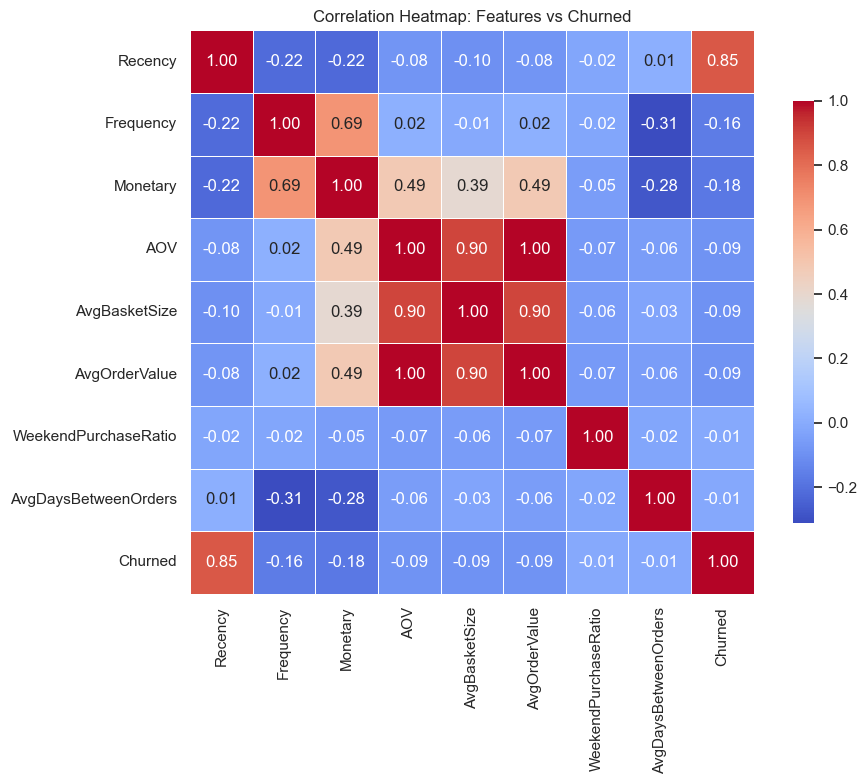

<Figure size 1000x600 with 0 Axes>

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine X_train and y_train for correlation analysis
corr_df = X_train.copy()
corr_df['Churned'] = y_train

# Compute correlation matrix
corr_matrix = corr_df.corr()

# Plot heatmap
fig = plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75}
)
plt.title("Correlation Heatmap: Features vs Churned")
plt.tight_layout()
save_figure(fig, "churn_feature_correlation_heatmap.png", "Phase5")
plt.show()
plt.clf()


In [101]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Train Random Forest on selected features
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Calculate and sort feature importances
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
importances_sorted = importances.sort_values(ascending=False)

# Display sorted feature importances
print("\nTop Features for Predicting Churn (Random Forest):")
print(importances_sorted)



Top Features for Predicting Churn (Random Forest):
Recency                 0.862047
Monetary                0.033440
Frequency               0.030555
AvgDaysBetweenOrders    0.022425
AOV                     0.016969
AvgOrderValue           0.015908
AvgBasketSize           0.013839
WeekendPurchaseRatio    0.004817
dtype: float64


Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase5\churn_rf_feature_importance.png


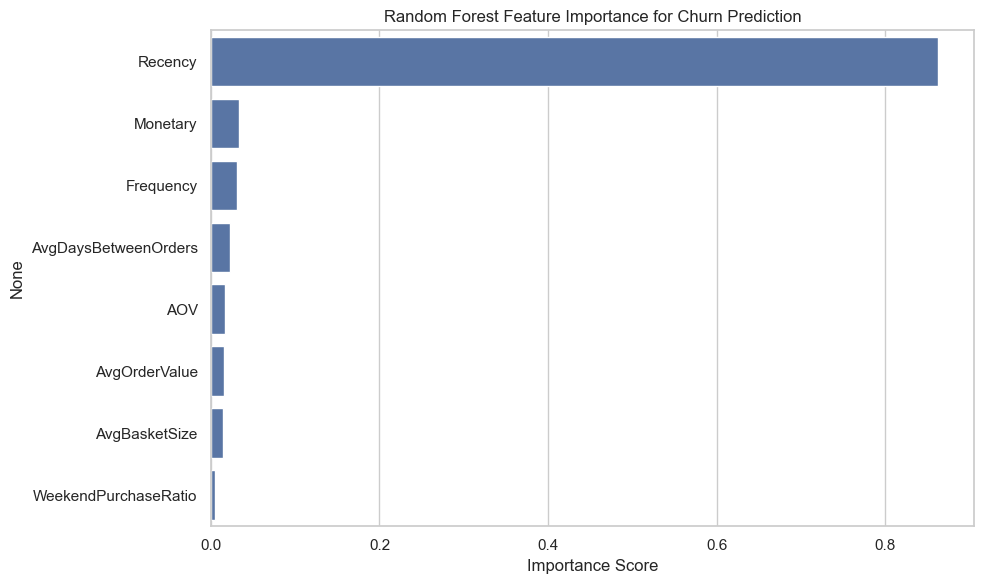

<Figure size 1000x600 with 0 Axes>

In [102]:
fig = plt.figure(figsize=(10, 6))
sns.barplot(
    x=importances_sorted.values,
    y=importances_sorted.index
)
plt.title("Random Forest Feature Importance for Churn Prediction")
plt.xlabel("Importance Score")
plt.tight_layout()
save_figure(fig, "churn_rf_feature_importance.png", "Phase5")  # Removed 'leakfree' from filename
plt.show()
plt.clf()

## Step 5.3 – Model Training (Churn Prediction)

In [103]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Apply SMOTE to balance the training dataset
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Summary of resampled training set
print(f"Training set shape after SMOTE: {X_train_smote.shape}")
print("Balanced class distribution (y_train_smote):")
print(y_train_smote.value_counts(normalize=True).map("{:.2%}".format))

# Define classification models (balanced, no need for class_weight)
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "MLP Neural Network": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
}

# Train all models
trained_models = {}

print("\nTraining models on SMOTE-balanced data...\n")
for name, model in models.items():
    model.fit(X_train_smote, y_train_smote)
    trained_models[name] = model
    print(f"Trained: {name}")


Training set shape after SMOTE: (3426, 8)
Balanced class distribution (y_train_smote):
Churned
0    50.00%
1    50.00%
Name: proportion, dtype: object

Training models on SMOTE-balanced data...

Trained: Logistic Regression
Trained: Support Vector Machine
Trained: Random Forest
Trained: XGBoost
[LightGBM] [Info] Number of positive: 1713, number of negative: 1713
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1818
[LightGBM] [Info] Number of data points in the train set: 3426, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

Trained: CatBoost
Trained: K-Nearest Neighbors
Trained: MLP Neural Network


## Step 5.4 – Final Model Evaluation (Churn Prediction)

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase5\churn_confusion_matrix_smote_logistic_regression.png


<Figure size 500x400 with 0 Axes>

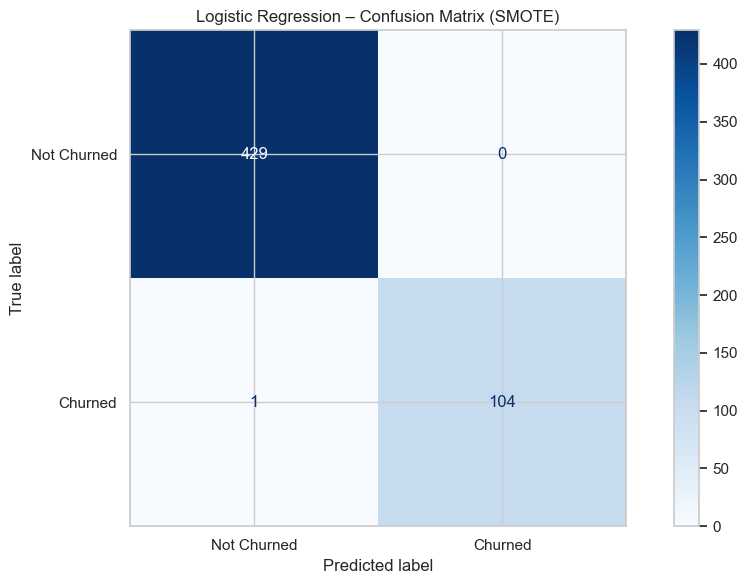

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase5\churn_confusion_matrix_smote_support_vector_machine.png


<Figure size 1000x600 with 0 Axes>

<Figure size 500x400 with 0 Axes>

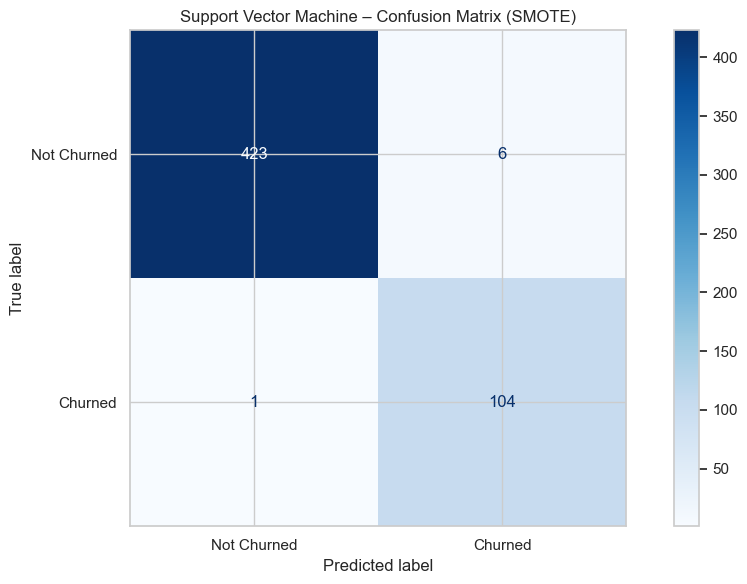

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase5\churn_confusion_matrix_smote_random_forest.png


<Figure size 1000x600 with 0 Axes>

<Figure size 500x400 with 0 Axes>

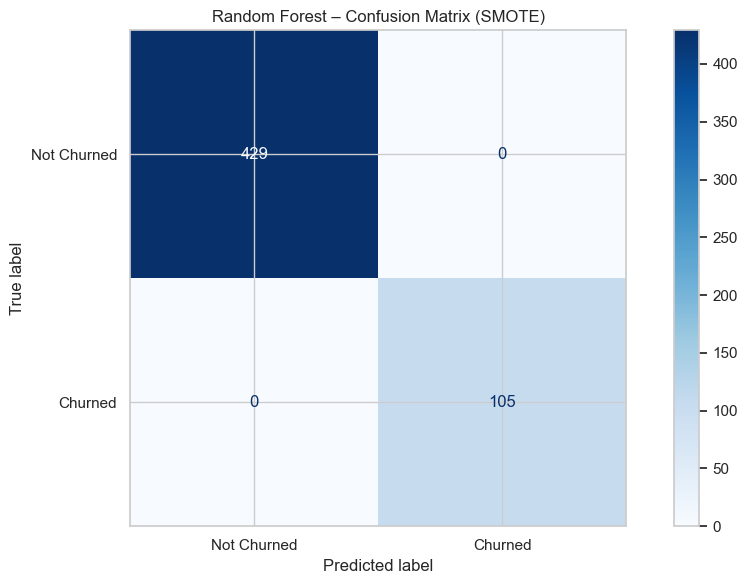

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase5\churn_confusion_matrix_smote_xgboost.png


<Figure size 1000x600 with 0 Axes>

<Figure size 500x400 with 0 Axes>

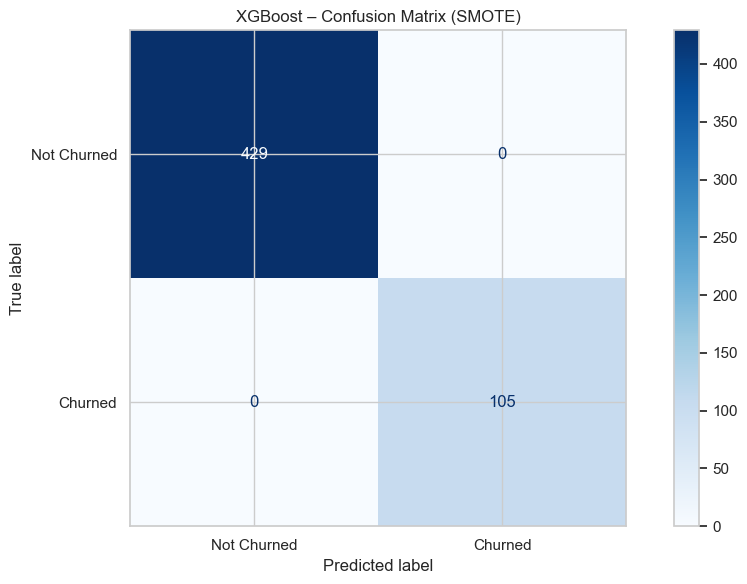

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase5\churn_confusion_matrix_smote_lightgbm.png


<Figure size 1000x600 with 0 Axes>

<Figure size 500x400 with 0 Axes>

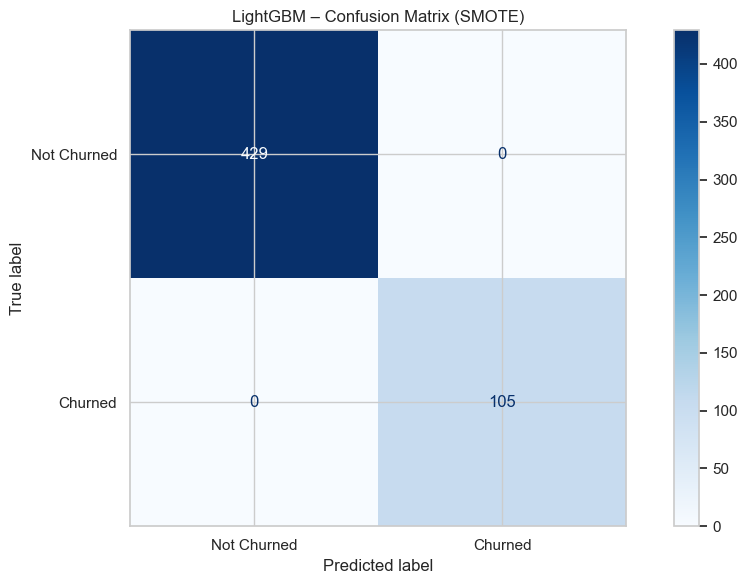

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase5\churn_confusion_matrix_smote_catboost.png


<Figure size 1000x600 with 0 Axes>

<Figure size 500x400 with 0 Axes>

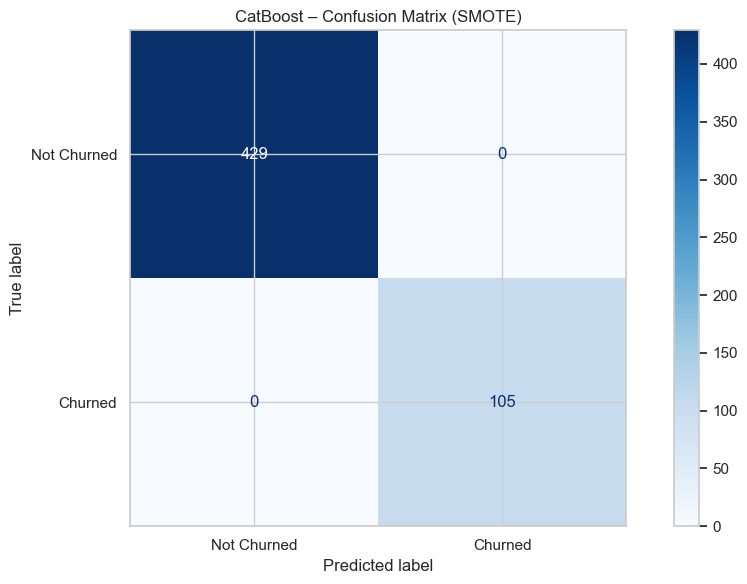

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase5\churn_confusion_matrix_smote_k-nearest_neighbors.png


<Figure size 1000x600 with 0 Axes>

<Figure size 500x400 with 0 Axes>

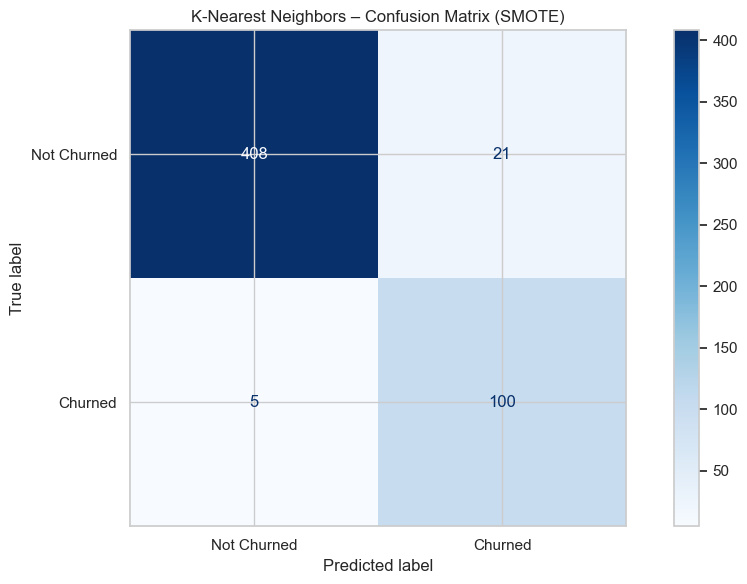

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase5\churn_confusion_matrix_smote_mlp_neural_network.png


<Figure size 1000x600 with 0 Axes>

<Figure size 500x400 with 0 Axes>

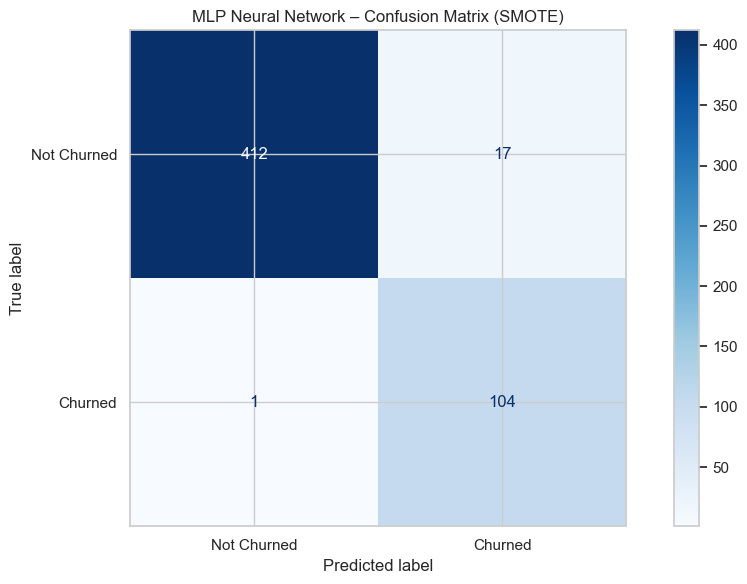

<Figure size 1000x600 with 0 Axes>

In [106]:
# Step 5.3.1: Evaluate Churn Classifiers – Metrics and Confusion Matrices

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

evaluation_results = []

# Evaluate each model
for name, model in trained_models.items():
    y_pred = model.predict(X_test)

    # Predict probabilities for ROC-AUC
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())  # normalize scores

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_proba)

    evaluation_results.append({
        'Model': name,
        'Accuracy': round(accuracy, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1-Score': round(f1, 4),
        'ROC-AUC': round(roc_auc, 4)
    })

    # Plot and save confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize=(5, 4))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Churned", "Churned"])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"{name} – Confusion Matrix (SMOTE)")
    plt.tight_layout()
    save_figure(fig, f"churn_confusion_matrix_smote_{name.replace(' ', '_').lower()}.png", "Phase5")
    plt.show()
    plt.clf()


In [107]:
from sklearn.metrics import classification_report

# Print classification report for each model
for name, model in trained_models.items():
    y_pred = model.predict(X_test)
    print("=" * 60)
    print(f"{name} – Classification Report (Churn):")
    print(classification_report(y_test, y_pred, target_names=["Not Churned", "Churned"]))

# Create and display final sorted comparison table
results_df = pd.DataFrame(evaluation_results).sort_values(by='ROC-AUC', ascending=False)

print("\nChurn Model Evaluation Summary (SMOTE Balanced):")
print(results_df.to_string(index=False))


Logistic Regression – Classification Report (Churn):
              precision    recall  f1-score   support

 Not Churned       1.00      1.00      1.00       429
     Churned       1.00      0.99      1.00       105

    accuracy                           1.00       534
   macro avg       1.00      1.00      1.00       534
weighted avg       1.00      1.00      1.00       534

Support Vector Machine – Classification Report (Churn):
              precision    recall  f1-score   support

 Not Churned       1.00      0.99      0.99       429
     Churned       0.95      0.99      0.97       105

    accuracy                           0.99       534
   macro avg       0.97      0.99      0.98       534
weighted avg       0.99      0.99      0.99       534

Random Forest – Classification Report (Churn):
              precision    recall  f1-score   support

 Not Churned       1.00      1.00      1.00       429
     Churned       1.00      1.00      1.00       105

    accuracy              

### Cross Validation

In [108]:
# Step 5.3.3: Cross-Validation for Churn Classifiers

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer

# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0),
    'roc_auc': 'roc_auc'
}

# Set up Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store CV results
cv_results = []

print("\nCross-Validation Results (5-Fold on SMOTE-Balanced Data):")
for name, model in trained_models.items():
    result = {'Model': name}
    for metric_name, scorer in scoring.items():
        scores = cross_val_score(model, X_train_smote, y_train_smote, scoring=scorer, cv=cv)
        result[metric_name.capitalize()] = round(np.mean(scores), 4)
    cv_results.append(result)
    print(f"Completed: {name}")

# Display sorted results
cv_df = pd.DataFrame(cv_results).sort_values(by='Roc_auc', ascending=False)
print("\nAverage CV Scores (Sorted by ROC-AUC):")
print(cv_df.to_string(index=False))



Cross-Validation Results (5-Fold on SMOTE-Balanced Data):
Completed: Logistic Regression
Completed: Support Vector Machine
Completed: Random Forest
Completed: XGBoost
[LightGBM] [Info] Number of positive: 1370, number of negative: 1370
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1815
[LightGBM] [Info] Number of data points in the train set: 2740, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 1371, number of negative: 1370
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1816
[LightGBM] [Info] Number of data points in the train set: 2741, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500182 -> initscore=0.000730
[LightGBM] [Info] Start training from score 0.000730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1370, number of negative: 1371
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1818
[LightGBM] [Info] Number of data points in the train set: 27

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 1371, number of negative: 1370
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1815
[LightGBM] [Info] Number of data points in the train set: 2741, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500182 -> initscore=0.000730
[LightGBM] [Info] Start training from score 0.000730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Completed: LightGBM
Compl

## Save The Best Model for Churn Prediction

In [110]:
import joblib
import os

# Create model export folder
model_folder = os.path.join(project_root, "Models", "Churn")
os.makedirs(model_folder, exist_ok=True)

# Save best churn model: XGBoost
best_model = trained_models["XGBoost"]
model_path = os.path.join(model_folder, "churn_model_xgboost.pkl")
joblib.dump(best_model, model_path)

print(f"Churn model (XGBoost) saved to: {model_path}")


Churn model (XGBoost) saved to: CustomerSegmentAI360\Models\Churn\churn_model_xgboost.pkl


# Model 2: CLV Prediction

## Step 5.1 — Train-Test Split & Prediction for CLV

In [111]:
from sklearn.model_selection import train_test_split

# Create binary target column
rfm['CLV_High'] = (rfm['CLV_Tier'] == 'High').astype(int)

# Define safe features to use (same as churn)
safe_features = [
    'Recency', 'Frequency', 'Monetary', 'AOV',
    'AvgBasketSize', 'AvgOrderValue',
    'WeekendPurchaseRatio', 'AvgDaysBetweenOrders'
]

# Drop rows with missing values in features or target
clv_df = rfm.dropna(subset=safe_features + ['CLV_High'])

# Define features and target
X_clv = clv_df[safe_features]
y_clv = clv_df['CLV_High']

# Train-test split (80/20 stratified)
X_clv_train, X_clv_test, y_clv_train, y_clv_test = train_test_split(
    X_clv, y_clv, test_size=0.2, random_state=42, stratify=y_clv
)

# Summary
print(f"Features used: {safe_features}")
print(f"Train shape: {X_clv_train.shape}, Test shape: {X_clv_test.shape}")
print("\nClass distribution in training set (CLV_High):")
print(y_clv_train.value_counts(normalize=True).map("{:.2%}".format))


Features used: ['Recency', 'Frequency', 'Monetary', 'AOV', 'AvgBasketSize', 'AvgOrderValue', 'WeekendPurchaseRatio', 'AvgDaysBetweenOrders']
Train shape: (2133, 8), Test shape: (534, 8)

Class distribution in training set (CLV_High):
CLV_High
0    61.32%
1    38.68%
Name: proportion, dtype: object


## Step 5.2 – Feature Importance & Correlation (for CLV)

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase5\high_clv_feature_correlation_heatmap.png


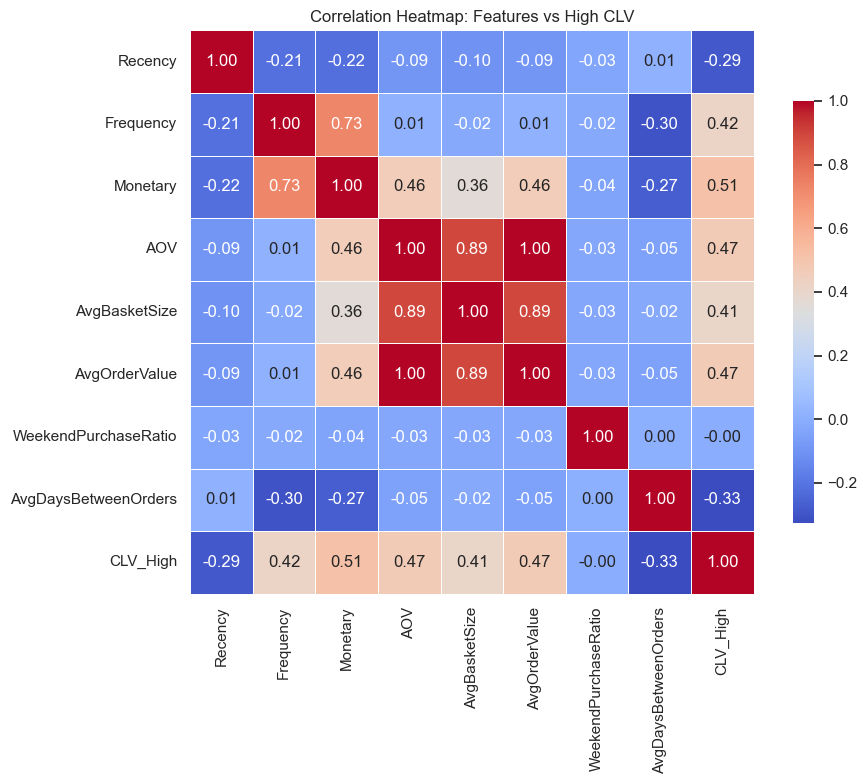

<Figure size 1000x600 with 0 Axes>

In [114]:
# Combine features and target
corr_clv_df = X_clv_train.copy()
corr_clv_df['CLV_High'] = y_clv_train

# Compute correlation matrix
clv_corr_matrix = corr_clv_df.corr()

# Plot heatmap
fig = plt.figure(figsize=(10, 8))
sns.heatmap(
    clv_corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75}
)
plt.title("Correlation Heatmap: Features vs High CLV")
plt.tight_layout()
save_figure(fig, "high_clv_feature_correlation_heatmap.png", "Phase5")
plt.show()
plt.clf()


In [112]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Train Random Forest on High CLV classification
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_clv_train, y_clv_train)

# Compute feature importances
clv_importances = pd.Series(rf_clf.feature_importances_, index=X_clv_train.columns)
clv_importances_sorted = clv_importances.sort_values(ascending=False)

# Display top features
print("\nTop Features for Predicting High CLV (Random Forest):")
print(clv_importances_sorted)



Top Features for Predicting High CLV (Random Forest):
Monetary                0.571496
Frequency               0.215594
AvgOrderValue           0.070259
AOV                     0.067649
AvgBasketSize           0.031202
AvgDaysBetweenOrders    0.029634
Recency                 0.011346
WeekendPurchaseRatio    0.002820
dtype: float64


Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase5\high_clv_rf_feature_importance.png


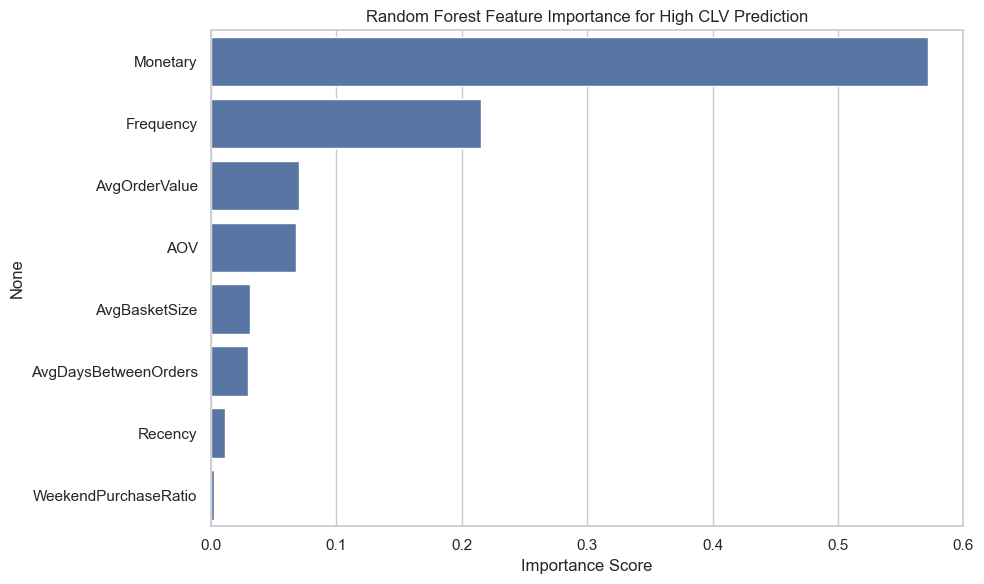

<Figure size 1000x600 with 0 Axes>

In [113]:
# Plot Feature Importance – High CLV (Random Forest)

fig = plt.figure(figsize=(10, 6))
sns.barplot(
    x=clv_importances_sorted.values,
    y=clv_importances_sorted.index
)
plt.title("Random Forest Feature Importance for High CLV Prediction")
plt.xlabel("Importance Score")
plt.tight_layout()
save_figure(fig, "high_clv_rf_feature_importance.png", "Phase5")
plt.show()
plt.clf()


## Step 5.3 – Model Training (Churn Prediction)

In [116]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Define models (no class_weight needed for balanced data)
clv_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "MLP Neural Network": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
}

# Train and store models
trained_clv_models = {}

print("\nTraining models for High CLV prediction...\n")
for name, model in clv_models.items():
    model.fit(X_clv_train, y_clv_train)
    trained_clv_models[name] = model
    print(f"Trained: {name}")



Training models for High CLV prediction...

Trained: Logistic Regression
Trained: Support Vector Machine
Trained: Random Forest
Trained: XGBoost
[LightGBM] [Info] Number of positive: 825, number of negative: 1308
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1793
[LightGBM] [Info] Number of data points in the train set: 2133, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.386779 -> initscore=-0.460871
[LightGBM] [Info] Start training from score -0.460871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

###  Step 5.4 - Evaluate Models for High CLV Prediction

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase5\high_clv_conf_matrix_logistic_regression.png


<Figure size 500x400 with 0 Axes>

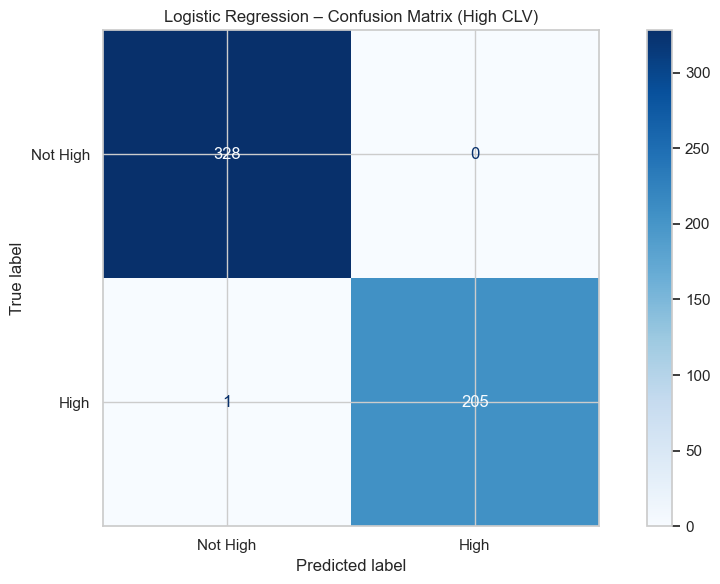

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase5\high_clv_conf_matrix_support_vector_machine.png


<Figure size 1000x600 with 0 Axes>

<Figure size 500x400 with 0 Axes>

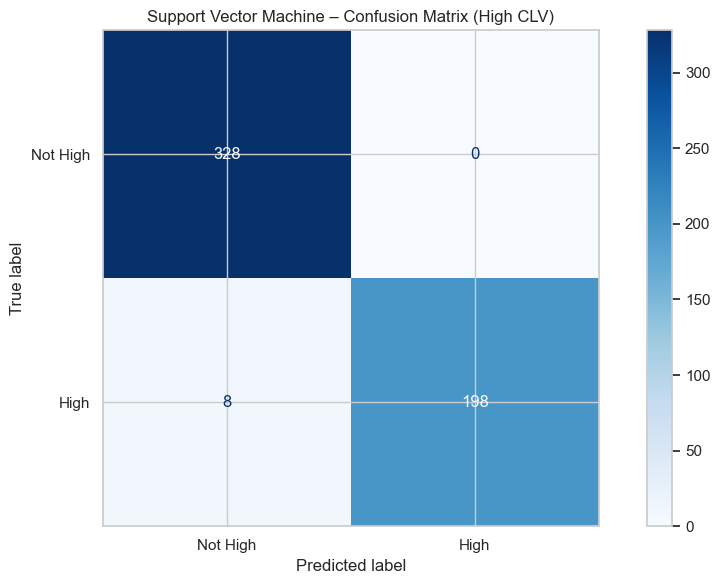

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase5\high_clv_conf_matrix_random_forest.png


<Figure size 1000x600 with 0 Axes>

<Figure size 500x400 with 0 Axes>

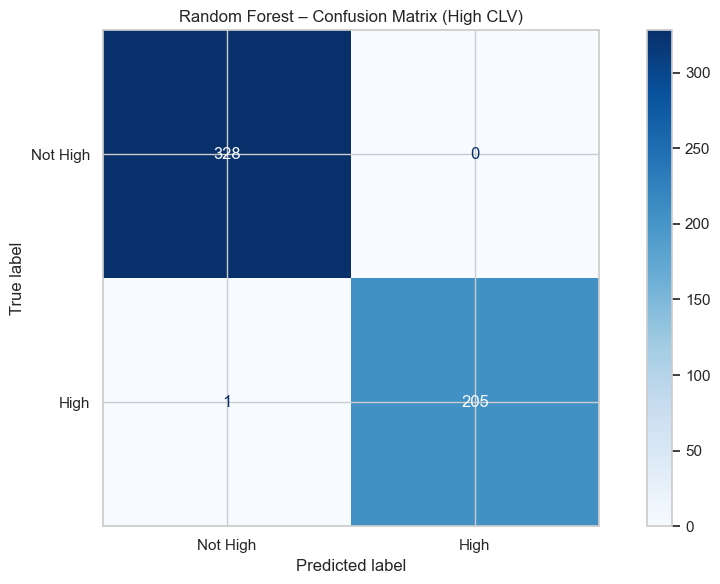

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase5\high_clv_conf_matrix_xgboost.png


<Figure size 1000x600 with 0 Axes>

<Figure size 500x400 with 0 Axes>

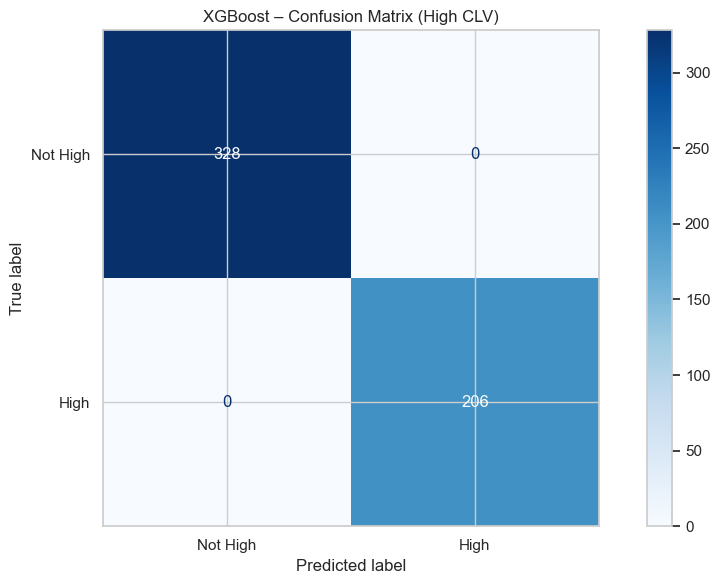

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase5\high_clv_conf_matrix_lightgbm.png


<Figure size 1000x600 with 0 Axes>

<Figure size 500x400 with 0 Axes>

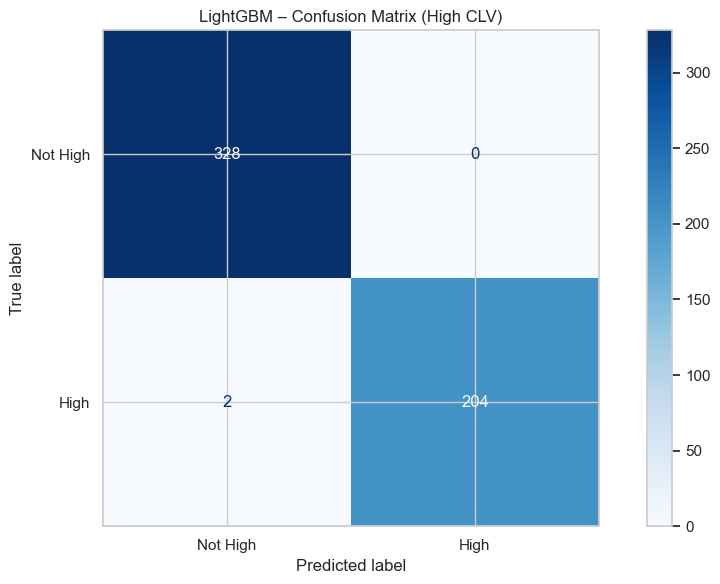

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase5\high_clv_conf_matrix_catboost.png


<Figure size 1000x600 with 0 Axes>

<Figure size 500x400 with 0 Axes>

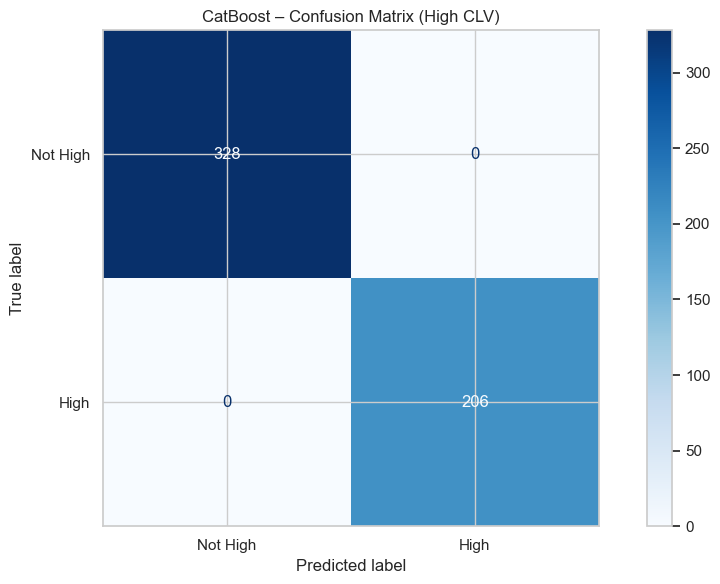

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase5\high_clv_conf_matrix_k-nearest_neighbors.png


<Figure size 1000x600 with 0 Axes>

<Figure size 500x400 with 0 Axes>

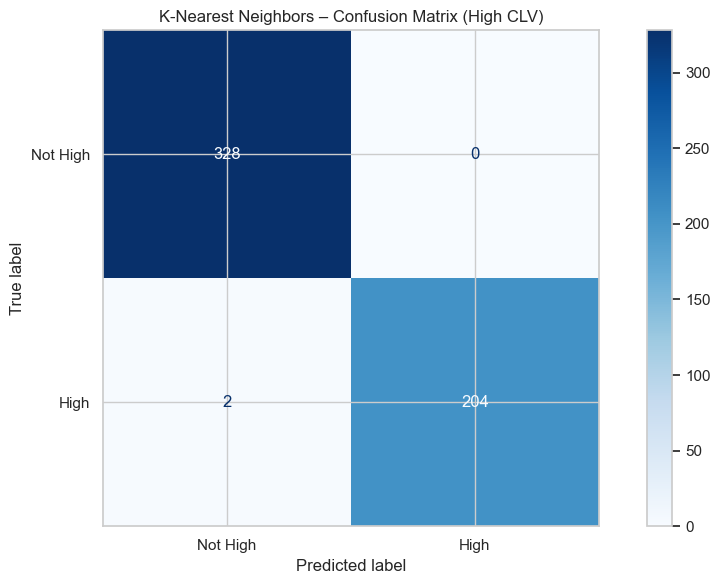

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase5\high_clv_conf_matrix_mlp_neural_network.png


<Figure size 1000x600 with 0 Axes>

<Figure size 500x400 with 0 Axes>

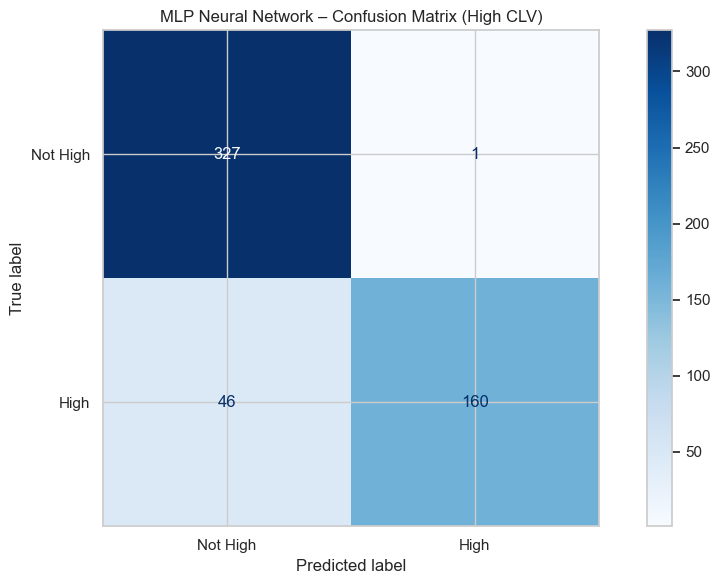

<Figure size 1000x600 with 0 Axes>

In [117]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    ConfusionMatrixDisplay, classification_report
)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

clv_eval_results = []

for name, model in trained_clv_models.items():
    y_pred = model.predict(X_clv_test)

    # Get predicted probabilities for ROC-AUC
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_clv_test)[:, 1]
    else:
        y_proba = model.decision_function(X_clv_test)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())

    # Evaluation metrics
    acc = accuracy_score(y_clv_test, y_pred)
    prec = precision_score(y_clv_test, y_pred, zero_division=0)
    rec = recall_score(y_clv_test, y_pred, zero_division=0)
    f1 = f1_score(y_clv_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_clv_test, y_proba)

    clv_eval_results.append({
        'Model': name,
        'Accuracy': round(acc, 4),
        'Precision': round(prec, 4),
        'Recall': round(rec, 4),
        'F1-Score': round(f1, 4),
        'ROC-AUC': round(auc, 4)
    })

    # Confusion Matrix
    cm = confusion_matrix(y_clv_test, y_pred)
    fig = plt.figure(figsize=(5, 4))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not High", "High"])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"{name} – Confusion Matrix (High CLV)")
    plt.tight_layout()
    save_figure(fig, f"high_clv_conf_matrix_{name.replace(' ', '_').lower()}.png", "Phase5")
    plt.show()
    plt.clf()


In [118]:
# Classification Reports for High CLV Models

from sklearn.metrics import classification_report

# Print classification report for each model
for name, model in trained_clv_models.items():
    y_pred = model.predict(X_clv_test)
    print("=" * 60)
    print(f"{name} – Classification Report (High CLV):")
    print(classification_report(y_clv_test, y_pred, target_names=["Not High", "High"]))
    
# High CLV Model Evaluation Summary Table

clv_results_df = pd.DataFrame(clv_eval_results).sort_values(by='ROC-AUC', ascending=False)

print("\nHigh CLV Model Evaluation Summary:")
print(clv_results_df.to_string(index=False))


Logistic Regression – Classification Report (High CLV):
              precision    recall  f1-score   support

    Not High       1.00      1.00      1.00       328
        High       1.00      1.00      1.00       206

    accuracy                           1.00       534
   macro avg       1.00      1.00      1.00       534
weighted avg       1.00      1.00      1.00       534

Support Vector Machine – Classification Report (High CLV):
              precision    recall  f1-score   support

    Not High       0.98      1.00      0.99       328
        High       1.00      0.96      0.98       206

    accuracy                           0.99       534
   macro avg       0.99      0.98      0.98       534
weighted avg       0.99      0.99      0.98       534

Random Forest – Classification Report (High CLV):
              precision    recall  f1-score   support

    Not High       1.00      1.00      1.00       328
        High       1.00      1.00      1.00       206

    accuracy     

### Save The Best Model for Churn Prediction

In [119]:
import joblib
import os

# Create folder to save the model
clv_model_folder = os.path.join(project_root, "Models", "High_CLV")
os.makedirs(clv_model_folder, exist_ok=True)

# Select and save the best model
best_clv_model = trained_clv_models["XGBoost"]
clv_model_path = os.path.join(clv_model_folder, "high_clv_model_xgboost.pkl")
joblib.dump(best_clv_model, clv_model_path)

print(f"High CLV model (XGBoost) saved to: {clv_model_path}")


High CLV model (XGBoost) saved to: CustomerSegmentAI360\Models\High_CLV\high_clv_model_xgboost.pkl


## Step 5.1: Data Preparation – Segment Prediction

In [120]:
from sklearn.model_selection import train_test_split

# Target: Cluster label (multi-class)
segment_target = 'KMeans_Cluster'

# Use the same safe features as before
segment_features = [
    'Recency', 'Frequency', 'Monetary', 'AOV',
    'AvgBasketSize', 'AvgOrderValue',
    'WeekendPurchaseRatio', 'AvgDaysBetweenOrders'
]

# Drop rows with missing values
segment_df = rfm.dropna(subset=segment_features + [segment_target])

# Define features and target
X_seg = segment_df[segment_features]
y_seg = segment_df[segment_target]

# Train-test split (stratified)
X_seg_train, X_seg_test, y_seg_train, y_seg_test = train_test_split(
    X_seg, y_seg, test_size=0.2, random_state=42, stratify=y_seg
)

# Summary
print(f"Features used: {segment_features}")
print(f"Train shape: {X_seg_train.shape}, Test shape: {X_seg_test.shape}")
print("\nSegment distribution in training set:")
print(y_seg_train.value_counts(normalize=True).map("{:.2%}".format))


Features used: ['Recency', 'Frequency', 'Monetary', 'AOV', 'AvgBasketSize', 'AvgOrderValue', 'WeekendPurchaseRatio', 'AvgDaysBetweenOrders']
Train shape: (2133, 8), Test shape: (534, 8)

Segment distribution in training set:
KMeans_Cluster
3    47.59%
0    40.18%
1    11.91%
2     0.33%
Name: proportion, dtype: object


## Step 5.2: Train Models – Segment Prediction (KMeans_Cluster)

In [121]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Define multi-class models
segment_models = {
    "Logistic Regression": LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "MLP Neural Network": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
}

# Train and store models
trained_segment_models = {}

print("\nTraining models for segment prediction (KMeans_Cluster)...\n")
for name, model in segment_models.items():
    model.fit(X_seg_train, y_seg_train)
    trained_segment_models[name] = model
    print(f"Trained: {name}")



Training models for segment prediction (KMeans_Cluster)...

Trained: Logistic Regression
Trained: Support Vector Machine
Trained: Random Forest
Trained: XGBoost
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1792
[LightGBM] [Info] Number of data points in the train set: 2133, number of used features: 8
[LightGBM] [Info] Start training from score -0.911847
[LightGBM] [Info] Start training from score -2.127950
[LightGBM] [Info] Start training from score -5.719375
[LightGBM] [Info] Start training from score -0.742641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

## Step 5.3: Evaluate Models – Segment Prediction (KMeans_Cluster)

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase5\segment_conf_matrix_logistic_regression.png


<Figure size 500x400 with 0 Axes>

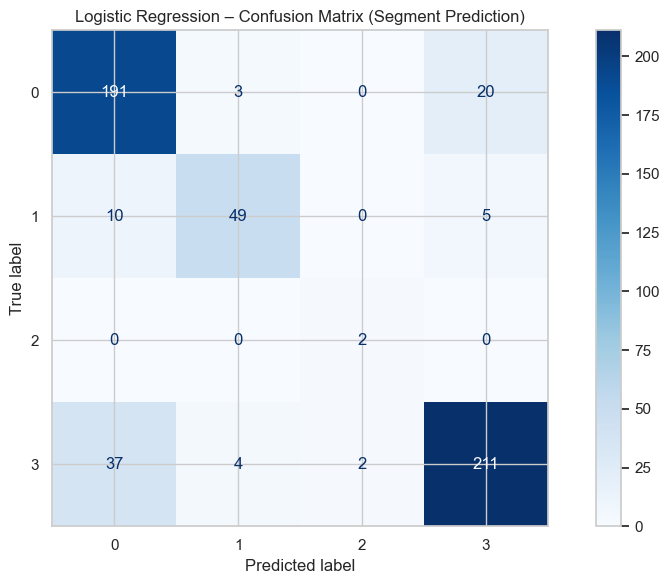

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase5\segment_conf_matrix_support_vector_machine.png


<Figure size 1000x600 with 0 Axes>

<Figure size 500x400 with 0 Axes>

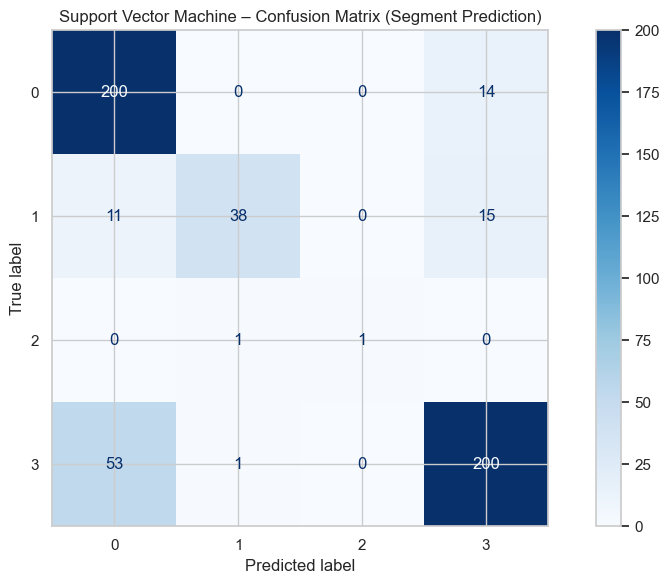

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase5\segment_conf_matrix_random_forest.png


<Figure size 1000x600 with 0 Axes>

<Figure size 500x400 with 0 Axes>

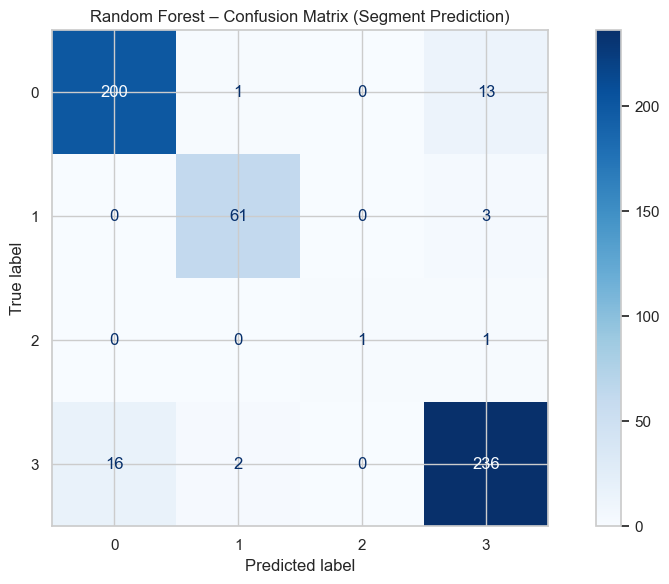

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase5\segment_conf_matrix_xgboost.png


<Figure size 1000x600 with 0 Axes>

<Figure size 500x400 with 0 Axes>

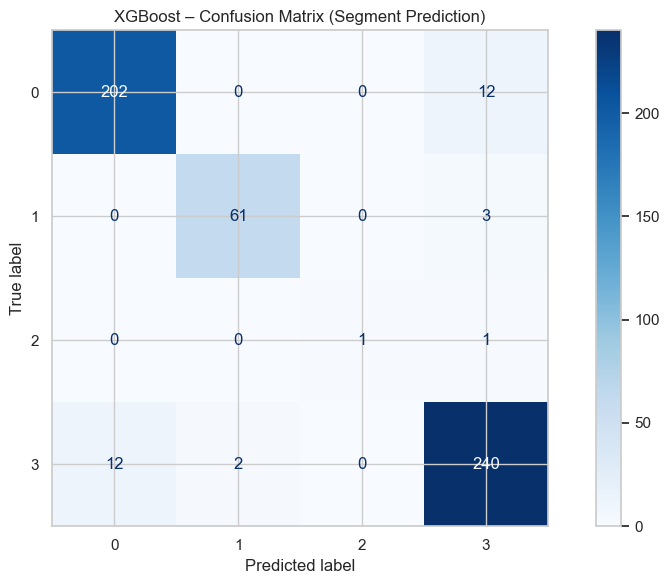

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase5\segment_conf_matrix_lightgbm.png


<Figure size 1000x600 with 0 Axes>

<Figure size 500x400 with 0 Axes>

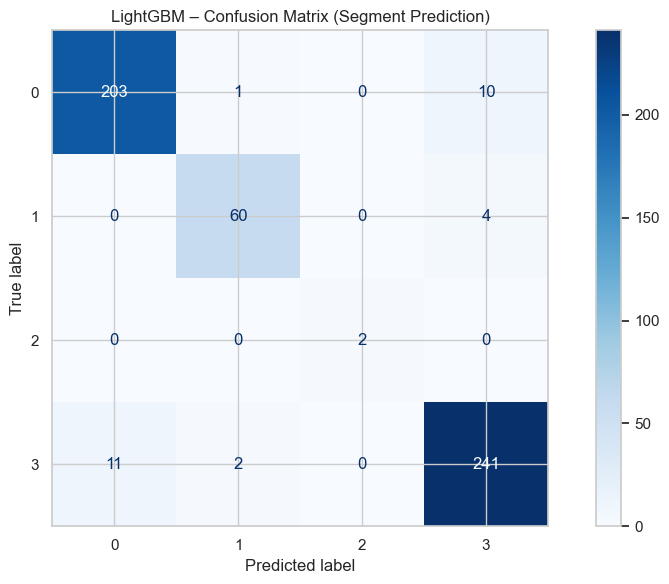

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase5\segment_conf_matrix_catboost.png


<Figure size 1000x600 with 0 Axes>

<Figure size 500x400 with 0 Axes>

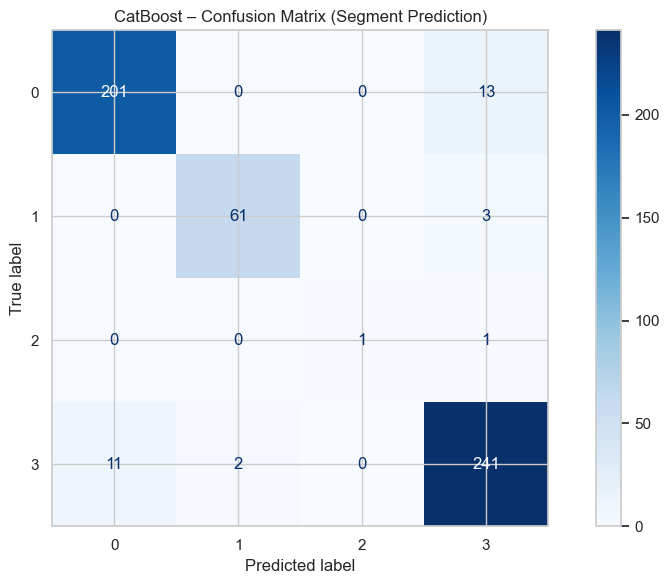

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase5\segment_conf_matrix_k-nearest_neighbors.png


<Figure size 1000x600 with 0 Axes>

<Figure size 500x400 with 0 Axes>

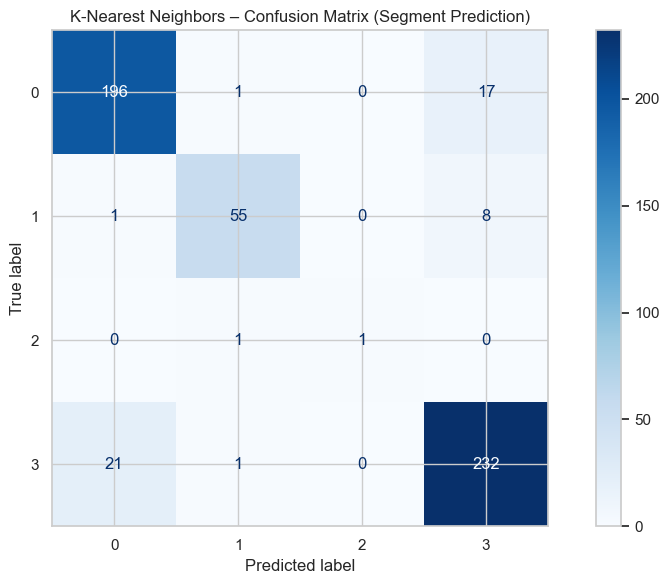

Saved figure: CustomerSegmentAI360\Outputs\Visuals\Phase5\segment_conf_matrix_mlp_neural_network.png


<Figure size 1000x600 with 0 Axes>

<Figure size 500x400 with 0 Axes>

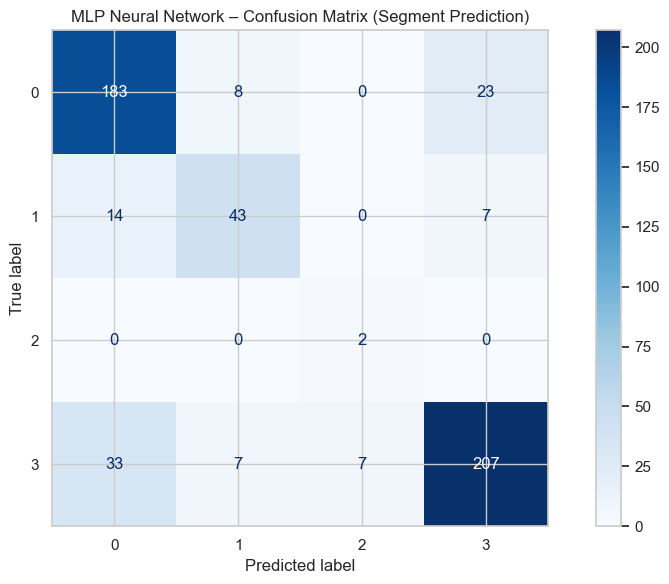

<Figure size 1000x600 with 0 Axes>

In [122]:
# Step 5.5.3: Evaluate Segment Models – KMeans_Cluster

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, ConfusionMatrixDisplay,
    classification_report
)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

segment_eval_results = []

for name, model in trained_segment_models.items():
    y_pred = model.predict(X_seg_test)

    # Evaluation metrics (macro for balanced multi-class)
    acc = accuracy_score(y_seg_test, y_pred)
    prec = precision_score(y_seg_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_seg_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_seg_test, y_pred, average='macro', zero_division=0)

    segment_eval_results.append({
        'Model': name,
        'Accuracy': round(acc, 4),
        'Precision (Macro)': round(prec, 4),
        'Recall (Macro)': round(rec, 4),
        'F1-Score (Macro)': round(f1, 4)
    })

    # Confusion Matrix
    cm = confusion_matrix(y_seg_test, y_pred)
    fig = plt.figure(figsize=(5, 4))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"{name} – Confusion Matrix (Segment Prediction)")
    plt.tight_layout()
    save_figure(fig, f"segment_conf_matrix_{name.replace(' ', '_').lower()}.png", "Phase5")
    plt.show()
    plt.clf()


## Step 5.4: Classification Reports – Predicting KMeans_Cluster

In [123]:
from sklearn.metrics import classification_report

for name, model in trained_segment_models.items():
    y_pred = model.predict(X_seg_test)
    print("=" * 60)
    print(f"{name} – Classification Report (KMeans_Cluster):")
    print(classification_report(y_seg_test, y_pred))

# Segment Prediction Model Evaluation Summary Table

segment_results_df = pd.DataFrame(segment_eval_results).sort_values(by='F1-Score (Macro)', ascending=False)

print("\nSegment Prediction Model Evaluation Summary (KMeans_Cluster):")
print(segment_results_df.to_string(index=False))


Logistic Regression – Classification Report (KMeans_Cluster):
              precision    recall  f1-score   support

           0       0.80      0.89      0.85       214
           1       0.88      0.77      0.82        64
           2       0.50      1.00      0.67         2
           3       0.89      0.83      0.86       254

    accuracy                           0.85       534
   macro avg       0.77      0.87      0.80       534
weighted avg       0.85      0.85      0.85       534

Support Vector Machine – Classification Report (KMeans_Cluster):
              precision    recall  f1-score   support

           0       0.76      0.93      0.84       214
           1       0.95      0.59      0.73        64
           2       1.00      0.50      0.67         2
           3       0.87      0.79      0.83       254

    accuracy                           0.82       534
   macro avg       0.90      0.70      0.77       534
weighted avg       0.84      0.82      0.82       534

Ran

### Save Final Segment Prediction Model – XGBoost

In [125]:
import joblib
import os

# Create folder to save the model
segment_model_folder = os.path.join(project_root, "Models", "Segment_Prediction")
os.makedirs(segment_model_folder, exist_ok=True)

# Save XGBoost segment model
best_segment_model = trained_segment_models["XGBoost"]
segment_model_path = os.path.join(segment_model_folder, "segment_model_xgboost.pkl")
joblib.dump(best_segment_model, segment_model_path)

print(f"Segment prediction model (XGBoost) saved to: {segment_model_path}")


Segment prediction model (XGBoost) saved to: CustomerSegmentAI360\Models\Segment_Prediction\segment_model_xgboost.pkl


## Save Final Dataset

In [129]:
# Save Final Enriched Dataset with Features & Predictions

rfm_export_path = os.path.join(project_root, "Processed", "rfm_final_dataset.csv")
os.makedirs(os.path.dirname(rfm_export_path), exist_ok=True)
rfm.to_csv(rfm_export_path, index=False)

print(f"Final enriched dataset saved to: {rfm_export_path}")


Final enriched dataset saved to: CustomerSegmentAI360\Processed\rfm_final_dataset.csv


# Load Models, Predict, Save Dataset

In [131]:
# Load libraries
import os
import joblib
import pandas as pd

# Define model paths
churn_model_path = os.path.join(project_root, "Models", "Churn", "churn_model_xgboost.pkl")
clv_model_path = os.path.join(project_root, "Models", "High_CLV", "high_clv_model_xgboost.pkl")
segment_model_path = os.path.join(project_root, "Models", "Segment_Prediction", "segment_model_xgboost.pkl")

# Load models
churn_model = joblib.load(churn_model_path)
clv_model = joblib.load(clv_model_path)
segment_model = joblib.load(segment_model_path)

print("All models loaded successfully.")

# Load final dataset (after all clustering + features were created)
rfm_path = os.path.join(project_root, "Processed", "rfm_final_dataset.csv")
rfm = pd.read_csv(rfm_path)

# Define model input features
model_features = [
    'Recency', 'Frequency', 'Monetary', 'AOV',
    'AvgBasketSize', 'AvgOrderValue',
    'WeekendPurchaseRatio', 'AvgDaysBetweenOrders'
]

# Prepare input for prediction
X_new = rfm[model_features]

# Make predictions
rfm['Churn_Pred'] = churn_model.predict(X_new)
rfm['High_CLV_Pred'] = clv_model.predict(X_new)
rfm['Segment_Pred'] = segment_model.predict(X_new)

# Optional: Map cluster prediction to segment label
if 'KMeans_Label' in rfm.columns and 'KMeans_Cluster' in rfm.columns:
    label_map = rfm[['KMeans_Cluster', 'KMeans_Label']].drop_duplicates().set_index('KMeans_Cluster')['KMeans_Label'].to_dict()
    rfm['Segment_Pred_Label'] = rfm['Segment_Pred'].map(label_map)

# Safe preview of key predictions
cols_to_show = ['CustomerID', 'Churn_Pred', 'High_CLV_Pred', 'Segment_Pred']
if 'Segment_Pred_Label' in rfm.columns:
    cols_to_show.append('Segment_Pred_Label')

print("\nSample Predictions:")
print(rfm[cols_to_show].head())

# Save updated dataset with predictions
rfm_updated_path = os.path.join(project_root, "Processed", "rfm_final_with_predictions.csv")
rfm.to_csv(rfm_updated_path, index=False)

print(f"\nUpdated dataset with predictions saved to: {rfm_updated_path}")


All models loaded successfully.

Sample Predictions:
   CustomerID  Churn_Pred  High_CLV_Pred  Segment_Pred
0     12747.0           0              1             3
1     12748.0           0              1             2
2     12748.0           0              1             2
3     12749.0           0              1             1
4     12820.0           0              0             3

Updated dataset with predictions saved to: CustomerSegmentAI360\Processed\rfm_final_with_predictions.csv
